In [1]:
# Importar las bibliotecas necesarias
import sys
import os
import pandas as pd
from sklearn.exceptions import NotFittedError
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Configuracion de seaborn
sns.set_theme(style='whitegrid', context='paper', palette='muted')

# Agregar el directorio de scripts al path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'scripts'))

# Importar el logger personalizado
from logger import CustomLogger

# Crear logger
logger = CustomLogger(developer='David')
app_logger = logger.get_logger('app')
errors_logger = logger.get_logger('errors')
visualizations_logger = logger.get_logger('visualizations')
optimization_logger = logger.get_logger('optimization')
results_logger = logger.get_logger('results')




In [2]:
try:
    # Cargar los datos de entrenamiento
    train_data = pd.read_csv('../data/train.csv', index_col='Id')
    app_logger.info("Conjunto de datos de entrenamiento cargado exitosamente.")
except FileNotFoundError:
    errors_logger.error("No se pudo encontrar el archivo de datos de entrenamiento.")
    raise
except Exception as e:
    errors_logger.error(f"Error al cargar los datos de entrenamiento: {str(e)}")
    raise

# Cargamos test.csv
try:
    test_data = pd.read_csv('../data/test.csv', index_col='Id')
    app_logger.info("Conjunto de datos de test cargado exitosamente.")
except FileNotFoundError:
    errors_logger.error("No se pudo encontrar el archivo de datos de test.")
    raise

# Mostrar las primeras filas del conjunto de datos
train_data.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
try:
    # Valores faltantes
    print("Valores faltantes por columna:")
    valores_faltantes = train_data.isnull().sum()
    porcentaje_faltantes = 100 * train_data.isnull().sum() / len(train_data)
    tabla_faltantes = pd.concat([valores_faltantes, porcentaje_faltantes], axis=1, keys=['Total', 'Porcentaje'])
    print(tabla_faltantes[tabla_faltantes['Total'] > 0].sort_values('Total', ascending=False))

    # Filas duplicadas
    filas_duplicadas = train_data.duplicated().sum()
    print(f"\nNúmero de filas duplicadas: {filas_duplicadas}")

    # Registrar en el log
    if valores_faltantes.sum() > 0:
        app_logger.info(f"Se encontraron {valores_faltantes.sum()} valores faltantes en total.")
    else:
        app_logger.info("No se encontraron valores faltantes en el conjunto de datos.")

    if filas_duplicadas > 0:
        app_logger.warning(f"Se encontraron {filas_duplicadas} filas duplicadas en el conjunto de datos.")
    else:
        app_logger.info("No se encontraron filas duplicadas en el conjunto de datos.")

except Exception as e:
    errors_logger.exception("Error al analizar valores faltantes y filas duplicadas:")
    app_logger.error("Se produjo un error al analizar los datos. Consulte el registro de errores para más detalles.")

Valores faltantes por columna:
              Total  Porcentaje
PoolQC         1453   99.520548
MiscFeature    1406   96.301370
Alley          1369   93.767123
Fence          1179   80.753425
MasVnrType      872   59.726027
FireplaceQu     690   47.260274
LotFrontage     259   17.739726
GarageType       81    5.547945
GarageYrBlt      81    5.547945
GarageFinish     81    5.547945
GarageQual       81    5.547945
GarageCond       81    5.547945
BsmtFinType2     38    2.602740
BsmtExposure     38    2.602740
BsmtFinType1     37    2.534247
BsmtCond         37    2.534247
BsmtQual         37    2.534247
MasVnrArea        8    0.547945
Electrical        1    0.068493

Número de filas duplicadas: 0


## Missing Columns on Train
- Pool Quality Col has 99,52% missing values, but we still have Pool Area wich i think is more important than PoolQc
- MiscFeature Col has 96.30% missing values. We also have MiscVal that represents the value of Misc Feature.
    - Each Misc Feature has a unique value or has multiple values?? If each MiscFeature has only one unique value (univoque relationship) we can drop MiscFeature and leave Misc Val because we wont lose info, otherwise, drop both. Even if MiscVal has no NaNs, using it on its own may not be the best for the model to gather relationships.
- Alley has 93% missing values, no other col is related to this one so we can directly drop it.


## Verificar si la relación es unívoca entre MiscFeature y MiscVal

In [4]:
try:
    # Crear un DataFrame con MiscFeature y MiscVal
    misc_df = train_data[['MiscFeature', 'MiscVal']]
    app_logger.info("DataFrame misc_df creado exitosamente")
except KeyError as e:
    errors_logger.exception("Error al crear misc_df: Columna no encontrada")
    print(f"Error: No se encontró la columna {str(e)} en el conjunto de datos")
    raise

try:
    # Agrupar por MiscFeature y contar los valores únicos de MiscVal
    relacion_misc = misc_df.groupby('MiscFeature')['MiscVal'].nunique().reset_index()
    relacion_misc.columns = ['MiscFeature', 'Valores_Unicos_MiscVal']
    app_logger.info("Relación entre MiscFeature y MiscVal generada correctamente")
except Exception as e:
    errors_logger.exception("Error al generar la relación entre MiscFeature y MiscVal")
    print("Se produjo un error al analizar la relación. Consulte el registro de errores para más detalles.")
    raise

print("Relación entre MiscFeature y MiscVal:")
print(relacion_misc)

try:
    # Verificar si cada MiscFeature tiene un único valor de MiscVal
    es_univoca = (relacion_misc['Valores_Unicos_MiscVal'] == 1).all()
    
    if es_univoca:
        print("\nLa relación entre MiscFeature y MiscVal es unívoca.")
        app_logger.info("La relación entre MiscFeature y MiscVal es unívoca. Se puede considerar dejar una columna.")
    else:
        print("\nLa relación entre MiscFeature y MiscVal no es unívoca.")
        app_logger.info("La relación entre MiscFeature y MiscVal no es unívoca. Se recomienda eliminar ambas columnas.")
except Exception as e:
    errors_logger.exception("Error al verificar la univocidad de la relación")
    print("Se produjo un error al verificar la relación. Consulte el registro de errores para más detalles.")

if not es_univoca:
    try:
        print("\nEjemplos de MiscFeature con múltiples valores de MiscVal:")
        ejemplos_multiples = relacion_misc[relacion_misc['Valores_Unicos_MiscVal'] > 1]
        for _, row in ejemplos_multiples.iterrows():
            feature = row['MiscFeature']
            valores = misc_df[misc_df['MiscFeature'] == feature]['MiscVal'].unique()
            print(f"MiscFeature: {feature}")
            print(f"Valores de MiscVal: {valores}\n")
            app_logger.info(f"MiscFeature '{feature}' tiene múltiples valores: {valores}")
    except Exception as e:
        errors_logger.exception("Error al mostrar ejemplos de MiscFeature con múltiples valores")
        print("Se produjo un error al mostrar los ejemplos. Consulte el registro de errores para más detalles.")

Relación entre MiscFeature y MiscVal:
  MiscFeature  Valores_Unicos_MiscVal
0        Gar2                       2
1        Othr                       2
2        Shed                      18
3        TenC                       1

La relación entre MiscFeature y MiscVal no es unívoca.

Ejemplos de MiscFeature con múltiples valores de MiscVal:
MiscFeature: Gar2
Valores de MiscVal: [15500  8300]

MiscFeature: Othr
Valores de MiscVal: [3500    0]

MiscFeature: Shed
Valores de MiscVal: [ 700  350  500  400  480  450 1200  800 2000  600 1300   54  620  560
 1400    0 1150 2500]



In [5]:
# Dado que MiscVal y MiscFeature no son univocamente relacionados, se eliminan ambas columnas puesto que estan relacionadas y no se tienen datos de una y la otra son casi todo 0
train_data = train_data.drop(columns=['MiscFeature', 'MiscVal'])
app_logger.info("Se eliminaron las columnas MiscFeature y MiscVal")

In [6]:
# # Importar dtale
# import dtale

# # Crear una instancia de dtale con los datos filtrados
# d = dtale.show(train_data_filtrado)

# # Mostrar el enlace para acceder a la interfaz de dtale
# print("Se ha generado un análisis interactivo con dtale.")
# print(f"Por favor, acceda a la siguiente URL para explorar los datos: {d._url}")

# # Registrar en el log
# app_logger.info("Se ha generado un análisis interactivo utilizando dtale.")


## Analysis D-Tale
- We found important predictive power with the following features ``FullBath_quantile, FullBath, GrLiveArea, GrLiveArea_power, GrLiveArea_quantile,GrLiveArea_robust, GarageCars, OverallQual``
- Maybe add a feature that stratifies if the house has garage or not (Never Mind ``GarageCond`` and ``GarageQual`` already do).
- 81 houses have 0 car capacity in garage and 0 sqft but not NA specified on ``GarageCond``, ``GarageQual``, ``GarageType`` and ``GarageFinish``, drop rows with 0 or impute them. If a house has 0 for ``GarageCars`` and ``GarageArea``, the ``GarageType``, ``GarageCond``, ``GarageQual``, and ``GarageFinish`` should be NA?.
- ``GarageQual`` and ``GarageCond`` are duplicates.
- The features ``Fireplaces`` and ``FireplaceQu`` are both NaN or 0 for the same row, so imputation should be done simultaneosly maintaining their possible relationship, imputing the mean and most frecuent values independently could potentially introduce noise as the pairing could possibly be random.

- Most of the numerical variables where Non-normal, with log relationship with sales price (target).

    ### Low Variance Features
    - Dtale showed the following features having low variance:
        - ``BsmtFinSF2`` : 88.56% are 0s, related to this feature we have ``BsmtFinType2`` with 88.33% of rows with value 'Unf' which means 'unfinished '. This could mean that as it is unfinshed the sqft on ``BsmtFinSF2`` are not taken into account so the value will be 0?. Coincidence percentaje between ``BsmtFinType2 == 'Unf' and BsmtFinSF2 == 0``: 97.14%
        - ``LowQualFinSF``: 98.22% are 0s. This feature represents 'Low quality finished square feet (all floors)', i dont really know if we could impute this values as the meaning of the variable is not deterministic or easy to define because it represent the sqft of LowQuality finished sqft of all floors, but there isnt a feature defining wich houses are LowQuality or finished. 
            - Maybe we could create a feature called ``Total_sqft`` and/or Mean between all floors per house, etc... 
        - ``KitchenAbvGr``: From possible values {0,1,2,3} 95.34% are 1s. These feature represents the number of kitchens above grade. There is also the ``TotRmsAbvGrd`` feature measuring the total rooms above grade and the feature ``KitchenQual`` wich indicates the quality of the kitchens. Due to this i think we could drop this feature and leave the other two, as the model will probably discover the relationships.
        - ``PoolArea``: 99.52% values are 0s. The related feature was ``PoolQC`` representing the pool quality but it had 99.79% of NaNs values so i think we can drop both.
        - ``EnclosedPorch``: 85.75% of 0s.
        - ``3SsnPorch``: 98.36% of 0s.
        - ``ScreenPorch``: 92.05% of 0s.
        - Out of this 3 features realted with sqft of different types of Porch the one that has the most sens on maintaining on the dataset is ``EnclosedPorch`` that is de opposite to ``OpenPorch`` (that measures the open porch sqft) and its not that much full of 0s as the other two. This could be okay with te model as it can learn that if we have some value on ``EnclosedPorch``, the house has an enclosed porch, and the same for ``OpenPorch``. The other 2 features are practically all 0s and not much value can be obtained. I think the 2 important features are the ones i mentioned, we could do some new features to encode this info of having 1 porch or another or both.
        

In [7]:
Low_Variance_Features = [
    "BsmtFinSF2",
    "LowQualFinSF",
    "KitchenAbvGr",
    "PoolArea",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch"
]
Low_Variance_Features_to_drop = [
    "BsmtFinSF2",
    "LowQualFinSF",
    "KitchenAbvGr",
    "PoolArea",
    "3SsnPorch",
    "ScreenPorch"
]

In [8]:
try:
    # Comparar YearRemodAdd con YearBuilt para identificar casas remodeladas
    casas_remodeladas = train_data[train_data['YearRemodAdd'] != train_data['YearBuilt']]
    casas_no_remodeladas = train_data[train_data['YearRemodAdd'] == train_data['YearBuilt']]

    # Calcular el número de casas remodeladas y no remodeladas
    num_remodeladas = len(casas_remodeladas)
    num_no_remodeladas = len(casas_no_remodeladas)

    # Imprimir los resultados
    print(f"Número de casas remodeladas: {num_remodeladas}")
    print(f"Número de casas no remodeladas: {num_no_remodeladas}")
    print(f"Porcentaje de casas remodeladas: {(num_remodeladas / len(train_data)) * 100:.2f}%")

    # Registrar en el log
    app_logger.info(f"Se identificaron {num_remodeladas} casas remodeladas y {num_no_remodeladas} casas no remodeladas.")

except KeyError as e:
    errors_logger.exception(f"Error al acceder a las columnas: {str(e)}")
    app_logger.error("No se pudo completar el análisis de casas remodeladas debido a un error en las columnas.")
except ZeroDivisionError:
    errors_logger.exception("Error al calcular el porcentaje: División por cero.")
    app_logger.error("No se pudo calcular el porcentaje de casas remodeladas debido a un error en los datos.")
except Exception as e:
    errors_logger.exception(f"Error inesperado durante el análisis de casas remodeladas: {str(e)}")
    app_logger.error("Se produjo un error inesperado durante el análisis de casas remodeladas.")


Número de casas remodeladas: 696
Número de casas no remodeladas: 764
Porcentaje de casas remodeladas: 47.67%


In [9]:
def calcular_porcentajes(df):
    '''
    Calcula el porcentaje de casas que coinciden en el año de construcción con el año de construcción del garaje y el año de remodelación.
    '''
    try:
        coinciden = df['YearBuilt'] == df['GarageYrBlt']
        diferentes = ~coinciden
        porcentaje_coinciden = (coinciden.sum() / len(df)) * 100
        porcentaje_diferentes = (diferentes.sum() / len(df)) * 100
        return porcentaje_coinciden, porcentaje_diferentes
    except KeyError as e:
        app_logger.error(f"Error al acceder a las columnas: {e}")
        raise
    except Exception as e:
        app_logger.error(f"Error inesperado al calcular porcentajes: {e}")
        raise

In [10]:
def analizar_coincidencias_remod(df, diferentes):
    '''
    Analiza las casas que coinciden en el año de construcción con el año de construcción del garaje y el año de remodelación.
    '''
    try:
        coinciden_con_remod = df[diferentes]['GarageYrBlt'] == df[diferentes]['YearRemodAdd']
        porcentaje_coinciden_remod = (coinciden_con_remod.sum() / diferentes.sum()) * 100
        return porcentaje_coinciden_remod
    except KeyError as e:
        app_logger.error(f"Error al acceder a las columnas para análisis de remodelación: {e}")
        raise
    except Exception as e:
        app_logger.error(f"Error inesperado en análisis de remodelación: {e}")
        raise

In [11]:
def calcular_diferencias_tiempo(df):
    '''
    Calcula las diferencias de tiempo entre el año de construcción del garaje y el año de construcción y el año de remodelación.
    '''
    try:
        df['diff_with_yearbuilt'] = abs(df['GarageYrBlt'] - df['YearBuilt'])
        df['diff_with_yearremodadd'] = abs(df['GarageYrBlt'] - df['YearRemodAdd'])
        return df
    except KeyError as e:
        app_logger.error(f"Error al calcular diferencias de tiempo: {e}")
        raise
    except Exception as e:
        app_logger.error(f"Error inesperado al calcular diferencias de tiempo: {e}")
        raise

In [12]:
def analizar_proximidad(df, umbral=7):
    '''
    Analiza las casas que están dentro del umbral de proximidad con el año de construcción del garaje y el año de construcción y el año de remodelación.
    '''
    try:
        proxima_a_yearbuilt = df[df['diff_with_yearbuilt'] <= umbral]
        proxima_a_yearremodadd = df[df['diff_with_yearremodadd'] <= umbral]
        mas_de_umbral = df[(df['diff_with_yearbuilt'] > umbral) & (df['diff_with_yearremodadd'] > umbral)]
        return proxima_a_yearbuilt, proxima_a_yearremodadd, mas_de_umbral
    except KeyError as e:
        app_logger.error(f"Error al analizar proximidad: {e}")
        raise
    except Exception as e:
        app_logger.error(f"Error inesperado al analizar proximidad: {e}")
        raise

In [13]:
def calcular_tiempos_medios_extremos(df):
    '''
    Calcula los tiempos medios y extremos de la construcción y la remodelación.
    '''
    try:
        tiempo_construccion = df['GarageYrBlt'] - df['YearBuilt']
        tiempo_remodelacion = df['YearRemodAdd'] - df['GarageYrBlt']
        tiempo_hasta_remodelacion = df['YearRemodAdd'] - df['YearBuilt']
        
        return {
            'construccion': (tiempo_construccion.mean(), tiempo_construccion.min(), tiempo_construccion.max()),
            'remodelacion': (tiempo_remodelacion.mean(), tiempo_remodelacion.min(), tiempo_remodelacion.max()),
            'hasta_remodelacion': (tiempo_hasta_remodelacion.mean(), tiempo_hasta_remodelacion.min(), tiempo_hasta_remodelacion.max())
        }
    except KeyError as e:
        app_logger.error(f"Error al calcular tiempos medios y extremos: {e}")
        raise
    except Exception as e:
        app_logger.error(f"Error inesperado al calcular tiempos medios y extremos: {e}")
        raise

In [14]:
def analizar_datos(df):
    '''
    Analiza los datos de construcción y remodelación.
    '''
    try:
        porcentaje_coinciden, porcentaje_diferentes = calcular_porcentajes(df)
        diferentes = df['YearBuilt'] != df['GarageYrBlt']
        porcentaje_coinciden_remod = analizar_coincidencias_remod(df, diferentes)
        
        no_coincide_ninguno = (~(df['YearBuilt'] == df['GarageYrBlt'])) & \
                              (~(df['GarageYrBlt'] == df['YearRemodAdd']))
        porcentaje_no_coincide_ninguno = (no_coincide_ninguno.sum() / len(df)) * 100
        
        df_no_coincide = calcular_diferencias_tiempo(df[no_coincide_ninguno])
        proxima_a_yearbuilt, proxima_a_yearremodadd, mas_de_7_anos = analizar_proximidad(df_no_coincide)
        
        porcentaje_proxima_a_yearbuilt = (len(proxima_a_yearbuilt) / len(df_no_coincide)) * 100
        porcentaje_proxima_a_yearremodadd = (len(proxima_a_yearremodadd) / len(df_no_coincide)) * 100
        porcentaje_mas_de_7_anos = (len(mas_de_7_anos) / len(df_no_coincide)) * 100
        porcentaje_mas_7_anos_total = (len(mas_de_7_anos) / len(df)) * 100
        
        tiempos = calcular_tiempos_medios_extremos(df)
        
        # Imprimir resultados
        print(f"Porcentaje de casas donde YearBuilt coincide con GarageYrBlt: {porcentaje_coinciden:.2f}%")
        print(f"Del {porcentaje_diferentes:.2f}% que no coincide con YearBuilt, {porcentaje_coinciden_remod:.2f}% coincide con YearRemodAdd")
        print(f"Porcentaje de casas donde GarageYrBlt no coincide ni con YearBuilt ni con YearRemodAdd: {porcentaje_no_coincide_ninguno:.2f}%")
        print(f"Porcentaje de casas donde GarageYrBlt está a más de 7 años de YearBuilt y YearRemodAdd respecto al total: {porcentaje_mas_7_anos_total:.2f}%")
        print(f"Porcentaje de casas donde GarageYrBlt no coincide con YearBuilt ni con YearRemodAdd y está a menos de 7 años de YearBuilt: {porcentaje_proxima_a_yearbuilt:.2f}%")
        print(f"Porcentaje de casas donde GarageYrBlt no coincide con YearBuilt ni con YearRemodAdd y está a menos de 7 años de YearRemodAdd: {porcentaje_proxima_a_yearremodadd:.2f}%")
        print(f"Porcentaje de casas donde GarageYrBlt no coincide con YearBuilt ni con YearRemodAdd y está a más de 7 años de ambas fechas: {porcentaje_mas_de_7_anos:.2f}%")
        
        for key, (media, minimo, maximo) in tiempos.items():
            print(f"Tiempo {key} - Media: {media:.2f}, Mínimo: {minimo:.2f}, Máximo: {maximo:.2f} años")
        
        # Registrar en el log
        app_logger.info(f"Análisis de YearBuilt vs GarageYrBlt completado. Coinciden: {porcentaje_coinciden:.2f}%, Diferentes: {porcentaje_diferentes:.2f}%")
        app_logger.info(f"El {porcentaje_no_coincide_ninguno:.2f}% de las casas tienen GarageYrBlt que no coincide ni con YearBuilt ni con YearRemodAdd.")
        app_logger.info(f"El {porcentaje_mas_7_anos_total:.2f}% del total de casas tienen GarageYrBlt a más de 7 años de YearBuilt y YearRemodAdd.")
        
    except Exception as e:
        app_logger.error(f"Error en el análisis de datos: {e}")
        raise

In [15]:
# Ejecutar el análisis
try:
    analizar_datos(train_data)
except Exception as e:
    app_logger.error(f"Error general en la ejecución del análisis: {e}")

Porcentaje de casas donde YearBuilt coincide con GarageYrBlt: 74.59%
Del 25.41% que no coincide con YearBuilt, 14.56% coincide con YearRemodAdd
Porcentaje de casas donde GarageYrBlt no coincide ni con YearBuilt ni con YearRemodAdd: 21.71%
Porcentaje de casas donde GarageYrBlt está a más de 7 años de YearBuilt y YearRemodAdd respecto al total: 9.45%
Porcentaje de casas donde GarageYrBlt no coincide con YearBuilt ni con YearRemodAdd y está a menos de 7 años de YearBuilt: 22.08%
Porcentaje de casas donde GarageYrBlt no coincide con YearBuilt ni con YearRemodAdd y está a menos de 7 años de YearRemodAdd: 23.03%
Porcentaje de casas donde GarageYrBlt no coincide con YearBuilt ni con YearRemodAdd y está a más de 7 años de ambas fechas: 43.53%
Tiempo construccion - Media: 5.55, Mínimo: -10.00, Máximo: 123.00 años
Tiempo remodelacion - Media: 6.93, Mínimo: -53.00, Máximo: 98.00 años
Tiempo hasta_remodelacion - Media: 13.60, Mínimo: 0.00, Máximo: 123.00 años


C:\Users\david\AppData\Local\Temp\ipykernel_40100\2723570695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_with_yearbuilt'] = abs(df['GarageYrBlt'] - df['YearBuilt'])
C:\Users\david\AppData\Local\Temp\ipykernel_40100\2723570695.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_with_yearremodadd'] = abs(df['GarageYrBlt'] - df['YearRemodAdd'])


In [16]:
def calcular_porcentaje(numerador, denominador):
    try:
        return (numerador / denominador) * 100
    except ZeroDivisionError:
        app_logger.warning("División por cero al calcular porcentaje")
        return 0

In [17]:
def analizar_bsmt_fin_type2(df):
    try:
        coincidencias = ((df['BsmtFinType2'] == 'Unf') & (df['BsmtFinSF2'] == 0)).sum()
        total_casos_0 = (df['BsmtFinSF2'] == 0).sum()
        porcentaje_coincidencia = calcular_porcentaje(coincidencias, total_casos_0)

        app_logger.info(f"El {porcentaje_coincidencia:.2f}% de los casos tienen BsmtFinType2 == 'Unf' y BsmtFinSF2 == 0 simultáneamente.")
        print(f"Porcentaje de coincidencia entre BsmtFinType2 == 'Unf' y BsmtFinSF2 == 0 del total de casas donde BsmtFinSF2 == 0: {porcentaje_coincidencia:.2f}%")

        no_coincidencias = ((df['BsmtFinType2'] == 'Unf') & (df['BsmtFinSF2'] != 0)).sum()
        total_casos_no_0 = (df['BsmtFinSF2'] != 0).sum()
        porcentaje_no_coincidencia = calcular_porcentaje(no_coincidencias, total_casos_no_0)

        app_logger.info(f"El {porcentaje_no_coincidencia:.2f}% de los casos tienen BsmtFinType2 == 'Unf' pero BsmtFinSF2 != 0. Con un total de {no_coincidencias} casos.")
        print(f"Porcentaje de casos donde BsmtFinType2 == 'Unf' pero BsmtFinSF2 != 0 respecto al total de casas donde BsmtFinSF2 != 0: {porcentaje_no_coincidencia:.2f}%")

        combinaciones_cero = df[df['BsmtFinSF2'] == 0]['BsmtFinType2'].value_counts()
        porcentaje_combinaciones = calcular_porcentaje(combinaciones_cero, len(df))

        print("Combinaciones con BsmtFinSF2 == 0:")
        for tipo, conteo in combinaciones_cero.items():
            porcentaje = porcentaje_combinaciones[tipo]
            print(f"BsmtFinType2 = '{tipo}': {conteo} casos ({porcentaje:.2f}%)")
            app_logger.info(f"BsmtFinType2 = '{tipo}': {porcentaje:.2f}% de los casos")

        porcentaje_total_cero = (df['BsmtFinSF2'] == 0).mean() * 100
        print(f"\nPorcentaje total de casos con BsmtFinSF2 == 0: {porcentaje_total_cero:.2f}%")
        app_logger.info(f"El {porcentaje_total_cero:.2f}% de los casos tienen BsmtFinSF2 == 0")

    except KeyError as e:
        app_logger.error(f"Error al acceder a las columnas del DataFrame: {e}")
    except Exception as e:
        app_logger.error(f"Error inesperado durante el análisis: {e}")

In [18]:
# Ejecutar el análisis
try:
    analizar_bsmt_fin_type2(train_data_filtrado)
except Exception as e:
    app_logger.error(f"Error general en la ejecución del análisis: {e}")

app_logger - ERROR - Error general en la ejecución del análisis: name 'train_data_filtrado' is not defined


## Datasets till now
At this point we have the following datasets:
- ``train_data`` : Original data with 80 columns. NaNs, Zeros, Low Variance, etc...

------------------

## XiCorr Coeficiente
El coeficiente Xicorr (Xi-correlation coefficient) es una medida de asociación entre dos variables que puede ser utilizada como alternativa al coeficiente de correlación de Pearson, especialmente cuando las variables no tienen una relación lineal.

### Definición del Coeficiente Xicorr

El coeficiente Xicorr se basa en la idea de las "permutaciones locales". Se enfoca en la desviación de las permutaciones locales de una relación ideal, y puede ser más robusto frente a distribuciones no normales y relaciones no lineales.

#### 1. Supongamos que tenemos dos variables $X$ e $Y$ con $n$ observaciones cada una.

$$ X = (X_1, X_2, \ldots, X_n) $$
$$ Y = (Y_1, Y_2, \ldots, Y_n) $$


#### 2. Ordenamos ambas variables en orden ascendente.

$$ X_{(1)}, X_{(2)}, \ldots, X_{(n)} $$
$$ Y_{(1)}, Y_{(2)}, \ldots, Y_{(n)} $$

#### 3. Calculamos las posiciones de los valores originales en los vectores ordenados. Denotamos las posiciones de $X_i$ en $X_{(i)}$ como $P_X(i)$ y de $Y_i$ en $Y_{(i)}$ como $P_Y(i)$.

$$ P_X(i) = \text{posición de } X_i \text{ en } X_{(i)} $$
$$ P_Y(i) = \text{posición de } Y_i \text{ en } Y_{(i)} $$

#### 4. Definimos las permutaciones locales $ \pi_X $ y $ \pi_Y $ de $X$ e $Y$ respectivamente, que representan cómo se permutan los valores cuando se ordenan.

#### 5. Calculamos la desviación de estas permutaciones locales de una relación ideal. Esta desviación se mide a través de una función de distancia. Una forma común de definir esta distancia es usar la distancia de Kendall ($ \tau $).

$$ \tau(\pi_X, \pi_Y) = \text{Número de discordancias entre } \pi_X \text{ y } \pi_Y $$

#### 6. Normalizamos esta distancia para obtener el coeficiente Xicorr. La normalización se hace para que el coeficiente esté en el rango [-1, 1], similar a los coeficientes de correlación tradicionales.

$$ \text{Xicorr}(X, Y) = 1 - \frac{2 \tau(\pi_X, \pi_Y)}{n(n-1)/2} $$

Aquí, $ n(n-1)/2 $ es el número total de pares posibles en el conjunto de datos.

### Interpretación del Coeficiente Xicorr

- **Xicorr = 1**: Indica una correlación perfecta y positiva entre las variables $X$ e $Y$.
- **Xicorr = -1**: Indica una correlación perfecta y negativa entre las variables $X$ e $Y$.
- **Xicorr = 0**: Indica que no hay correlación entre las variables $X$ e $Y$.

### Pasos Intuitivos del Cálculo del Coeficiente Xicorr

1. **Ordenación de las Variables**:
   - Imagina que tienes dos listas de números, una para cada variable, $X$ e $Y$. Primero, ordenas cada lista de menor a mayor.
   - Por ejemplo, si $X = [4, 1, 3]$, lo ordenas como $X_{ordenado} = [1, 3, 4]$. Lo mismo haces con $Y$.

2. **Rastreo de las Posiciones Originales**:
   - Luego, haces un seguimiento de las posiciones originales de los elementos en las listas ordenadas. Es decir, determinas dónde estaba originalmente cada valor en la lista desordenada.
   - Por ejemplo, si $X = [4, 1, 3]$ y $X_{ordenado} = [1, 3, 4]$, el valor 1 estaba en la posición 2 originalmente, el 3 en la posición 3 y el 4 en la posición 1.

3. **Comparación de las Permutaciones**:
   - Ahora, haces lo mismo para la variable $Y$. Una vez que tienes las posiciones originales de ambos conjuntos de datos ordenados, puedes compararlas.
   - Imagina que tienes las posiciones originales de $X$ como $\pi_X$ y las posiciones originales de $Y$ como $\pi_Y$.

4. **Medición de la Discordancia**:
   - Comparas estas permutaciones ($\pi_X$ y $\pi_Y$) para ver cuán diferentes son. La discordancia se mide contando cuántas veces un par de elementos está en un orden diferente en $X$ en comparación con $Y$.
   - Por ejemplo, si en $X$ el segundo elemento viene antes que el primero pero en $Y$ el primero viene antes que el segundo, eso es una discordancia.

5. **Calculo de la Distancia de Discordancia**:
   - La distancia de Kendall ($\tau$) es una forma común de medir esta discordancia, contando cuántas discordancias hay entre las posiciones de $X$ e $Y$.
   - Si hay muchas discordancias, significa que las listas están muy desalineadas.

6. **Normalización de la Distancia**:
   - Para obtener el coeficiente Xicorr, normalizas la cantidad de discordancias para que el valor resultante esté en un rango estándar (generalmente de -1 a 1).
   - La fórmula de normalización convierte la cantidad de discordancias en un valor que puede interpretarse como un coeficiente de correlación.

----------------

## Null treatment, feature encoding, type assignment and low variance treatment

In this section we will treat our dataset to prepare it for the feature selection process so we can obtain the maximum benefit from it. 

We will do the following:

1. **Null treatment** -  Dropping columns with more than 90% NaNs.
2. **Type assignment** - Defining the type of each feature.
3. **Feature encoding** - Encoding categorical features with label encoder(cardinals, ordinals with few unique values) and one hot encoder(ordinals with many unique values and purely categorical).
4. **Low variance treatment** - Dropping columns with low variance.

## 1. **Null Treatment**

### Dropping NaNs with more than 90%

In [19]:
try:
    # Filtrar columnas con más del 90% de valores faltantes
    umbral_faltantes = 0.9
    columnas_a_eliminar = tabla_faltantes[tabla_faltantes['Porcentaje'] > 90].index
    train_data_filtrado = train_data.drop(columns=columnas_a_eliminar.drop(['MiscFeature']))

    # Registrar en el log
    if len(columnas_a_eliminar) > 0:
        app_logger.info(f"Se eliminaron {len(columnas_a_eliminar)} columnas con más del 90% de valores faltantes: {', '.join(columnas_a_eliminar)}")
        print(f"Columnas eliminadas: {', '.join(columnas_a_eliminar.drop(['MiscFeature']))}")
    else:
        app_logger.info("No se encontraron columnas con más del 90% de valores faltantes.")
        print("No se encontraron columnas con más del 90% de valores faltantes.")

    # Mostrar la forma del nuevo conjunto de datos
    print(f"\nForma del conjunto de datos original: {train_data.shape}")
    print(f"Forma del conjunto de datos filtrado: {train_data_filtrado.shape}")

except KeyError as e:
    errors_logger.exception(f"Error al acceder a una columna: {str(e)}")
    app_logger.error("Se produjo un error al filtrar las columnas. Verifique los nombres de las columnas.")
except ValueError as e:
    errors_logger.exception(f"Error en el cálculo de porcentajes: {str(e)}")
    app_logger.error("Se produjo un error al calcular los porcentajes de valores faltantes.")
except Exception as e:
    errors_logger.exception(f"Error inesperado: {str(e)}")
    app_logger.error("Se produjo un error inesperado durante el procesamiento de los datos.")


Columnas eliminadas: Alley, PoolQC

Forma del conjunto de datos original: (1460, 78)
Forma del conjunto de datos filtrado: (1460, 76)


In [20]:
# Análisis de valores faltantes
app_logger.info("Iniciando análisis de valores faltantes...")

try:
    # Calcular el número de valores faltantes por columna
    missing_values = train_data_filtrado.isnull().sum()
    
    # Calcular el porcentaje de valores faltantes
    missing_percentage = 100 * missing_values / len(train_data_filtrado)
    
    # Crear un DataFrame con los resultados
    missing_table = pd.concat([missing_values, missing_percentage], axis=1, keys=['Valores Faltantes', 'Porcentaje'])
    
    # Ordenar el DataFrame por el número de valores faltantes en orden descendente
    missing_table = missing_table[missing_table['Valores Faltantes'] > 0].sort_values('Valores Faltantes', ascending=False)
    
    if not missing_table.empty:
        app_logger.info("Se encontraron las siguientes variables con valores faltantes:")
        for index, row in missing_table.iterrows():
            app_logger.info(f"  - {index}: {row['Valores Faltantes']} valores faltantes ({row['Porcentaje']:.2f}%)")
        
        print("Variables con valores faltantes:")
        print(missing_table)
    else:
        app_logger.info("No se encontraron variables con valores faltantes.")
        print("No hay variables con valores faltantes.")

except Exception as e:
    errors_logger.error(f"Error durante el análisis de valores faltantes: {e}")
    raise

app_logger.info("Análisis de valores faltantes completado.")


Variables con valores faltantes:
              Valores Faltantes  Porcentaje
Fence                      1179   80.753425
MasVnrType                  872   59.726027
FireplaceQu                 690   47.260274
LotFrontage                 259   17.739726
GarageType                   81    5.547945
GarageYrBlt                  81    5.547945
GarageFinish                 81    5.547945
GarageQual                   81    5.547945
GarageCond                   81    5.547945
BsmtExposure                 38    2.602740
BsmtFinType2                 38    2.602740
BsmtQual                     37    2.534247
BsmtCond                     37    2.534247
BsmtFinType1                 37    2.534247
MasVnrArea                    8    0.547945
Electrical                    1    0.068493


Tratamiento de nulos de ``GarageYrBlt``, ``GarageFinish``, ``GarageQual``, ``GarageCond``,``GarageType``


In [21]:
# Los 81 nulos de ``GarageYrBlt``, ``GarageFinish``, ``GarageQual``, ``GarageCond``,``GarageType`` son comunes?
# Comprobar si los NaNs coinciden en índice para las columnas especificadas
columnas_garage = ['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']
nans_coinciden = train_data_filtrado[columnas_garage].isnull().all(axis=1).sum()

if nans_coinciden > 0:
    app_logger.info(f"Los NaNs coinciden en índice para las columnas de garage en {nans_coinciden} filas.")
    print(f"Los NaNs coinciden en índice para las columnas de garage en {nans_coinciden} filas.")
else:
    app_logger.info("No hay coincidencias de NaNs en índice para las columnas de garage.")
    print("No hay coincidencias de NaNs en índice para las columnas de garage.")


Los NaNs coinciden en índice para las columnas de garage en 81 filas.


In [22]:
import random

# Verificar si los NaNs coinciden en índice para las columnas especificadas
if nans_coinciden > 0:
    # Filtrar las filas que no tienen NaNs en las columnas de garage
    filas_no_nulas = train_data_filtrado.dropna(subset=columnas_garage)
    
    # Seleccionar 81 muestras aleatorias de las filas no nulas
    muestras_aleatorias = filas_no_nulas.sample(n=81, random_state=42)
    
    # Obtener los índices de las filas con NaNs en las columnas de garage
    indices_nulos = train_data_filtrado[train_data_filtrado[columnas_garage].isnull().all(axis=1)].index
    
    # Reemplazar los NaNs con los valores de las muestras aleatorias
    for i, indice in enumerate(indices_nulos):
        train_data_filtrado.loc[indice, columnas_garage] = muestras_aleatorias[columnas_garage].iloc[i]
    
    app_logger.info("Se han imputado los NaNs de las columnas de garage con valores aleatorios de filas no nulas.")
    print("Se han imputado los NaNs de las columnas de garage con valores aleatorios de filas no nulas.")
else:
    app_logger.info("No hay coincidencias de NaNs en índice para las columnas de garage.")
    print("No hay coincidencias de NaNs en índice para las columnas de garage.")


Se han imputado los NaNs de las columnas de garage con valores aleatorios de filas no nulas.


Tratamiento de nulos de ``BsmtExposure`` ,``BsmtFinType2`` ,``BsmtQual`` ,``BsmtCond`` ,``BsmtFinType1``                 

In [23]:
# Comprobar si los NaNs coinciden en índice para las columnas especificadas
columnas_Bsmt = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
nans_coinciden = train_data_filtrado[columnas_Bsmt].isnull().all(axis=1).sum()

if nans_coinciden > 0:
    app_logger.info(f"Los NaNs coinciden en índice para las columnas de Bsmt en {nans_coinciden} filas.")
    print(f"Los NaNs coinciden en índice para las columnas de Bsmt en {nans_coinciden} filas.")
else:
    app_logger.info("No hay coincidencias de NaNs en índice para las columnas de Bsmt.")
    print("No hay coincidencias de NaNs en índice para las columnas de Bsmt.")

if nans_coinciden > 0:
    # Filtrar las filas que no tienen NaNs en las columnas de garage
    filas_no_nulas = train_data_filtrado.dropna(subset=columnas_Bsmt)
    
    # Seleccionar 81 muestras aleatorias de las filas no nulas
    muestras_aleatorias = filas_no_nulas.sample(n=81, random_state=42)
    
    # Obtener los índices de las filas con NaNs en las columnas de garage
    indices_nulos = train_data_filtrado[train_data_filtrado[columnas_Bsmt].isnull().all(axis=1)].index
    
    # Reemplazar los NaNs con los valores de las muestras aleatorias
    for i, indice in enumerate(indices_nulos):
        train_data_filtrado.loc[indice, columnas_Bsmt] = muestras_aleatorias[columnas_Bsmt].iloc[i]
    
    app_logger.info("Se han imputado los NaNs de las columnas de Bsmt con valores aleatorios de filas no nulas.")
    print("Se han imputado los NaNs de las columnas de Bsmt con valores aleatorios de filas no nulas.")
else:
    app_logger.info("No hay coincidencias de NaNs en índice para las columnas de Bsmt.")
    print("No hay coincidencias de NaNs en índice para las columnas de Bsmt.")

Los NaNs coinciden en índice para las columnas de Bsmt en 37 filas.
Se han imputado los NaNs de las columnas de Bsmt con valores aleatorios de filas no nulas.


Tratamiento de NaNs de ``MasVnrArea`` con ``MasVnrType``

Tratamos primero los 8 Nans de ``MasVnrArea``

In [24]:
def determinar_tipo_y_tratar_nans(X, columna):
    try:
        tipo = X[columna].dtype
        
        if np.issubdtype(tipo, np.number):
            if X[columna].nunique() < 20:
                app_logger.info(f"{columna} se considerará categórica debido a que tiene menos de 20 valores únicos.")
                es_categorica = True
            else:
                app_logger.info(f"{columna} se considerará numérica.")
                es_categorica = False
        else:
            app_logger.info(f"{columna} es categórica por su tipo de dato.")
            es_categorica = True
        
        if es_categorica:
            moda = X[columna].mode()[0]
            X[columna].fillna(moda, inplace=True)
            app_logger.info(f"Se han rellenado los NaNs de {columna} con la moda: {moda}")
        else:
            mediana = X[columna].median()
            X[columna].fillna(mediana, inplace=True)
            app_logger.info(f"Se han rellenado los NaNs de {columna} con la mediana: {mediana}")
        
        nans_restantes = X[columna].isna().sum()
        app_logger.info(f"NaNs restantes en {columna} después del tratamiento: {nans_restantes}")
        
    except KeyError:
        app_logger.error(f"La columna {columna} no existe en el DataFrame.")
    except Exception as e:
        app_logger.error(f"Error inesperado al procesar la columna {columna}: {str(e)}")

In [25]:
# Uso de la función
try:
    determinar_tipo_y_tratar_nans(train_data_filtrado, 'MasVnrArea')
except Exception as e:
    app_logger.error(f"Error general en el procesamiento: {str(e)}")

In [26]:
train_data_filtrado[['MasVnrArea','MasVnrType']].value_counts(dropna=False)

MasVnrArea  MasVnrType
0.0         NaN           867
120.0       BrkFace         7
180.0       BrkFace         7
108.0       BrkFace         6
16.0        BrkFace         6
                         ... 
205.0       Stone           1
            BrkFace         1
204.0       BrkFace         1
203.0       BrkFace         1
1600.0      BrkFace         1
Name: count, Length: 401, dtype: int64

Se observa que 867 de los 872 Nans de ``MasVnrType``deberian de ser 'None' ya que se corresponden con 0 en ``MasVnrArea`` sin embargo, son NaN, de modo que se procede a cambiar los NaN por 'None'



In [27]:
train_data_filtrado['MasVnrType'].fillna('None', inplace=True)

Tratamiento de NaNs de ``LotFrontage``

In [28]:
def tratar_nans_lotfrontage(X):
    try:
        mediana_LotFrontage = train_data_filtrado['LotFrontage'].median()
        train_data_filtrado['LotFrontage'].fillna(mediana_LotFrontage, inplace=True)
        app_logger.info(f"Se han rellenado los NaNs de LotFrontage con la mediana: {mediana_LotFrontage}")
        
        nans_restantes_LotFrontage = train_data_filtrado['LotFrontage'].isna().sum()
        app_logger.info(f"NaNs restantes en LotFrontage después del tratamiento: {nans_restantes_LotFrontage}")
        
        return train_data_filtrado
    except KeyError:
        app_logger.error("La columna 'LotFrontage' no existe en el DataFrame.")
        raise
    except Exception as e:
        app_logger.error(f"Error inesperado al tratar los NaNs de LotFrontage: {str(e)}")
        raise

In [29]:
# Uso de la función
try:
    train_data_filtrado = tratar_nans_lotfrontage(train_data_filtrado)
except Exception as e:
    app_logger.error(f"No se pudo completar el tratamiento de NaNs en LotFrontage: {str(e)}")


Tratamiento de NaNs de ``FireplaceQu``

In [30]:
train_data_filtrado[['FireplaceQu','Fireplaces']].value_counts(dropna=False)

FireplaceQu  Fireplaces
NaN          0             690
Gd           1             324
TA           1             259
Gd           2              54
TA           2              53
Fa           1              28
Po           1              20
Ex           1              19
             2               4
Fa           2               4
Gd           3               2
Ex           3               1
Fa           3               1
TA           3               1
Name: count, dtype: int64

Segun la descripción si FireplaceQu es NA es que no tiene fireplace, lo cual se ve reflejado en el campo Fireplaces == 0. Este value count demuestra que todos los NaN de FireplaceQu son 0 en Fireplaces.

Por lo tanto, la gestion va a ser unicamente cambiar NaN por el string correcto 'NA' que será una categoría valida



In [31]:
train_data_filtrado['FireplaceQu'].fillna('NA', inplace=True)

Tratamiento de NaNs de ``Fence``

In [32]:
train_data_filtrado[['Fence']].value_counts(dropna=False)

Fence
NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: count, dtype: int64

Volvemos a observar que según la descripción deberian ser 'NA' sin embargo estan como NaN por lo que se procede a cambiar los NaN por 'NA'



In [33]:
train_data_filtrado['Fence'].fillna('NA', inplace=True)

### Check the rest of NaNs not treated


In [34]:
train_data_filtrado.isnull().sum().sort_values(ascending=False)

Electrical      1
BsmtFinType2    1
BsmtExposure    1
2ndFlrSF        0
LowQualFinSF    0
               ..
MasVnrArea      0
MasVnrType      0
Exterior2nd     0
Exterior1st     0
SalePrice       0
Length: 76, dtype: int64

In [35]:
# just drop them
train_data_filtrado.dropna(inplace=True)
train_data_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 1 to 1460
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1457 non-null   int64  
 1   MSZoning       1457 non-null   object 
 2   LotFrontage    1457 non-null   float64
 3   LotArea        1457 non-null   int64  
 4   Street         1457 non-null   object 
 5   LotShape       1457 non-null   object 
 6   LandContour    1457 non-null   object 
 7   Utilities      1457 non-null   object 
 8   LotConfig      1457 non-null   object 
 9   LandSlope      1457 non-null   object 
 10  Neighborhood   1457 non-null   object 
 11  Condition1     1457 non-null   object 
 12  Condition2     1457 non-null   object 
 13  BldgType       1457 non-null   object 
 14  HouseStyle     1457 non-null   object 
 15  OverallQual    1457 non-null   int64  
 16  OverallCond    1457 non-null   int64  
 17  YearBuilt      1457 non-null   int64  
 18  YearRemodAdd 

## 2. **Type Assignment**

In [36]:
# Comprobar las variables asignadas como object
app_logger.info("Comprobando las variables y asignando el tipo correcto")
for column in train_data_filtrado.columns:
    # Contar los tipos únicos
    unique_values = train_data_filtrado[column].nunique()
    
    # Si son strings con pocos tipos
    if unique_values < 20:
        if train_data_filtrado[column].dtype == 'object':
            # Realizar un lowercase y eliminar elementos diferentes a letras y números
            train_data_filtrado[column] = train_data_filtrado[column].str.lower().str.replace('[^a-z0-9]', '', regex=True)
        
            # Asignar la variable como category
            train_data_filtrado[column] = train_data_filtrado[column].astype('category')
            app_logger.info(f"La variable {column} se ha convertido a tipo category.")

        if train_data_filtrado[column].dtype == 'int64': #Una variable int con menos de 20 unicos posiblemente sea una categorica cardinal u ordinal
            # Si la variable es int con menos de 20 valores únicos, se puede considerar como categórica
            train_data_filtrado[column] = train_data_filtrado[column].astype('category')
            app_logger.info(f"La variable {column} que era INT se ha convertido a tipo category.")

In [37]:
train_data_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 1 to 1460
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1457 non-null   category
 1   MSZoning       1457 non-null   category
 2   LotFrontage    1457 non-null   float64 
 3   LotArea        1457 non-null   int64   
 4   Street         1457 non-null   category
 5   LotShape       1457 non-null   category
 6   LandContour    1457 non-null   category
 7   Utilities      1457 non-null   category
 8   LotConfig      1457 non-null   category
 9   LandSlope      1457 non-null   category
 10  Neighborhood   1457 non-null   object  
 11  Condition1     1457 non-null   category
 12  Condition2     1457 non-null   category
 13  BldgType       1457 non-null   category
 14  HouseStyle     1457 non-null   category
 15  OverallQual    1457 non-null   category
 16  OverallCond    1457 non-null   category
 17  YearBuilt      1457 non-null   int64  

## 3. **Feature Encoding**

In [38]:
# Importar las bibliotecas necesarias
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Función para aplicar Label Encoding y convertir a tipo category
def aplicar_label_encoding(X, columna):
    try:
        le = LabelEncoder()
        X[columna] = le.fit_transform(X[columna])
        app_logger.info(f"Se aplicó Label Encoding a la columna {columna} y se convirtió a tipo category")
    except Exception as e:
        errors_logger.error(f"Error al aplicar Label Encoding a la columna {columna}: {str(e)}")
    return X

# Función para aplicar One-Hot Encoding
def aplicar_one_hot_encoding(X, columna):
    try:
        ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
        encoded = ohe.fit_transform(X[[columna]])
        encoded_df = pd.DataFrame(encoded, columns=[f"{columna}_{cat}" for cat in ohe.categories_[0][1:]])
        X = pd.concat([X.drop(columna, axis=1), encoded_df], axis=1)
        app_logger.info(f"Se aplicó One-Hot Encoding a la columna {columna}")
    except Exception as e:
        errors_logger.error(f"Error al aplicar One-Hot Encoding a la columna {columna}: {str(e)}")
    return X

# Iterar sobre las columnas categóricas
for columna in train_data_filtrado.select_dtypes(include=['object', 'category']).columns:
    num_categorias = train_data_filtrado[columna].nunique()
    
    if num_categorias > 5:
        train_data_filtrado = aplicar_label_encoding(train_data_filtrado, columna)
    else:
        train_data_filtrado = aplicar_one_hot_encoding(train_data_filtrado, columna)

app_logger.info("Se ha completado el procesamiento de variables categóricas")

In [39]:
train_data_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 1 to 1380
Columns: 168 entries, MSSubClass to YrSold_nan
dtypes: float64(26), int32(136), int64(6)
memory usage: 1.1 MB


## 4. **Low Variance Treatment**

Sospecho que el low variance que surge en las variables principalmente categoricas es por aquellas categorías que están relacionadas con las casas de mayor precio y que hay pocas.

Planteamos una estrategia de oversampling para las casas por encima del umbral de Q3.

### Análisis visual para ver la distribución de los precios de las casas 

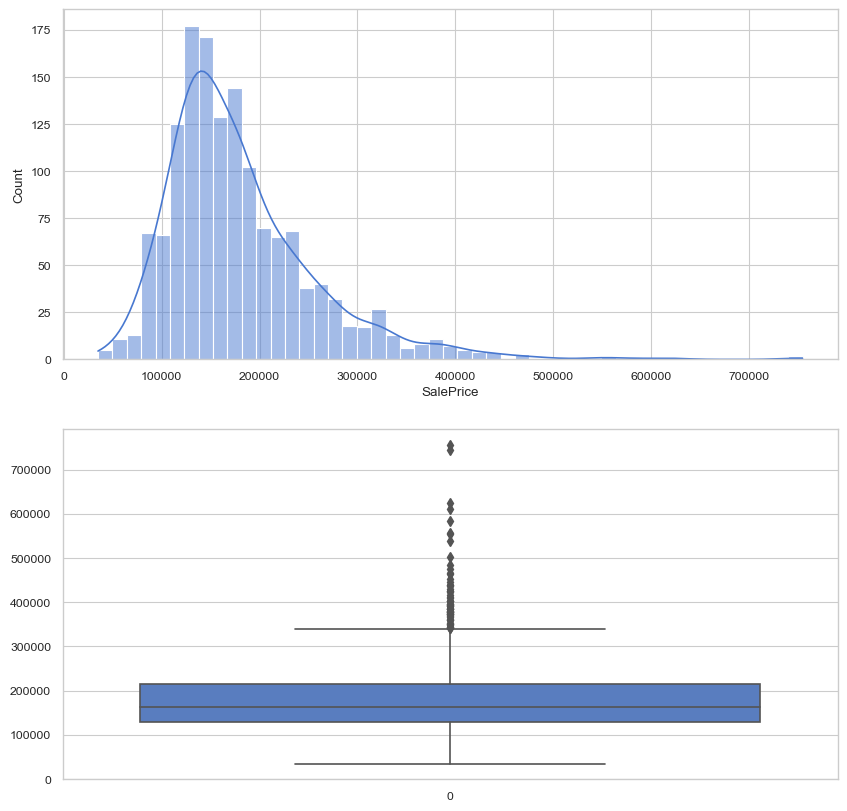

In [40]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

# Hacer un histplot de sales price con su kde correspondiente en seabron y hacer otro plot que sea un boxplot indicando los valores de sus quantiles
sns.histplot(train_data_filtrado['SalePrice'], kde=True, ax=ax[0])
sns.boxplot(train_data_filtrado['SalePrice'], ax=ax[1])

# Add log_SalePrice
train_data_filtrado['log_SalePrice'] = np.log(train_data_filtrado['SalePrice'])


### **Observación:**
Se observa un claro right skew como era de esperar en los precios de las casas puesto que se centran en precios bajos con colas largas en los precios altos.

### Precios por año de venta
Graficamos la distribucion de precios en función del año de venta para ver si algun año en concreto era el que contemplaba los precios mas altos.

<Axes: xlabel='YrSold', ylabel='SalePrice'>

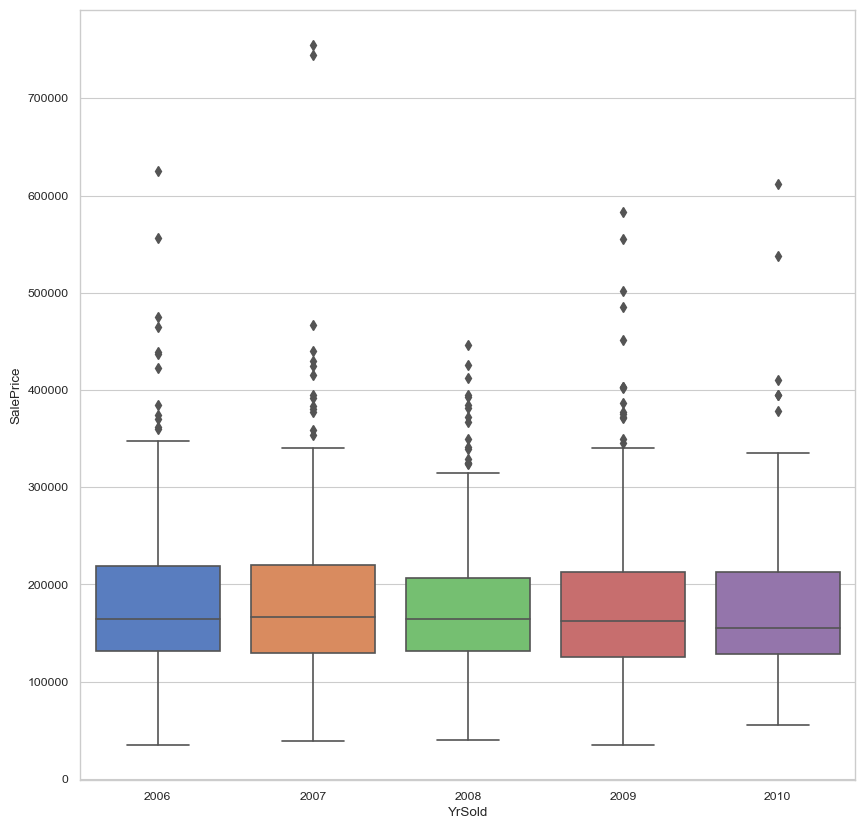

In [41]:
## Graficar la destribución de SalePrice en funcion de YrSold en train_data
# x=YrSold, y=SalePrice

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(train_data, x='YrSold', y='SalePrice', ax=ax)


## Estrategias de sobremuestreo de las casas con precios altos para intentar corregir el sesgo

### SMOGN

In [42]:
import smogn
## conduct smogn
housing_smogn = smogn.smoter(
    
    ## main arguments
    data = train_data_filtrado.dropna(),           ## pandas dataframe
    y = 'SalePrice',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'balance',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)
)

print(f"Tamaño original del dataset: {len(train_data_filtrado)}")
print(f"Tamaño del dataset después de SMOGN: {len(housing_smogn)}")

# Añadir log_SalePrice
housing_smogn['log_SalePrice'] = np.log(housing_smogn['SalePrice'])

r_index: 100%|##########| 86/86 [00:00<00:00, 252.96it/s]

Tamaño original del dataset: 1461
Tamaño del dataset después de SMOGN: 1239


### ADASYN

In [43]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

def adasyn_r(X, y, ratio=1.5, k=7):
    # Convertir a numpy arrays en caso de que los datos de entrada sean pandas DataFrame/Series
    X = np.asarray(X)
    y = np.asarray(y)
    
    # Calcular la densidad de los valores objetivo
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nn.kneighbors(X)
    
    densities = np.mean(distances[:, 1:], axis=1)
    normalized_densities = densities / np.sum(densities)
    
    # Calcular el número de muestras sintéticas a generar
    n_synthetic = int((ratio - 1) * len(X))
    n_synthetic_samples = np.rint(normalized_densities * n_synthetic).astype(int)
    print(f'Se generan {n_synthetic} muestras sintéticas')
    # Generar muestras sintéticas
    X_synthetic, y_synthetic = [], []
    for i, n in enumerate(n_synthetic_samples):
        if n == 0:
            continue
        nn_indices = indices[i, 1:]
        for _ in range(n):
            nn_idx = np.random.choice(nn_indices)
            t = np.random.random()
            
            X_new = X[i] + t * (X[nn_idx] - X[i])
            y_new = y[i] + t * (y[nn_idx] - y[i])
            X_synthetic.append(X_new)
            y_synthetic.append(y_new)
    
    # Verificar si se generaron muestras sintéticas
    if not X_synthetic:
        raise ValueError("No se generaron muestras sintéticas. Ajusta los parámetros de ADASYN.")
    
    return np.vstack([X, X_synthetic]), np.hstack([y, y_synthetic])

# Hacer el sobremuestreo y generar el dataframe
df = train_data_filtrado.copy()
df.dropna(inplace=True)
X_resampled, y_resampled = adasyn_r(df.drop('SalePrice', axis=1), df['SalePrice'])
adasyn_resampled = pd.DataFrame(X_resampled, columns=df.drop('SalePrice', axis=1).columns)
adasyn_resampled['SalePrice'] = y_resampled

app_logger.info("Se ha completado el oversampling de las casas con precio de venta por encima del Q3 utilizando ADASYN")

#Añadir log_SalePrice
adasyn_resampled['log_SalePrice'] = np.log(adasyn_resampled['SalePrice'])

Se generan 726 muestras sintéticas


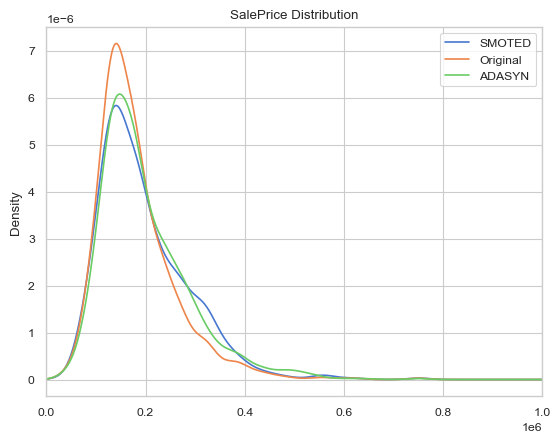

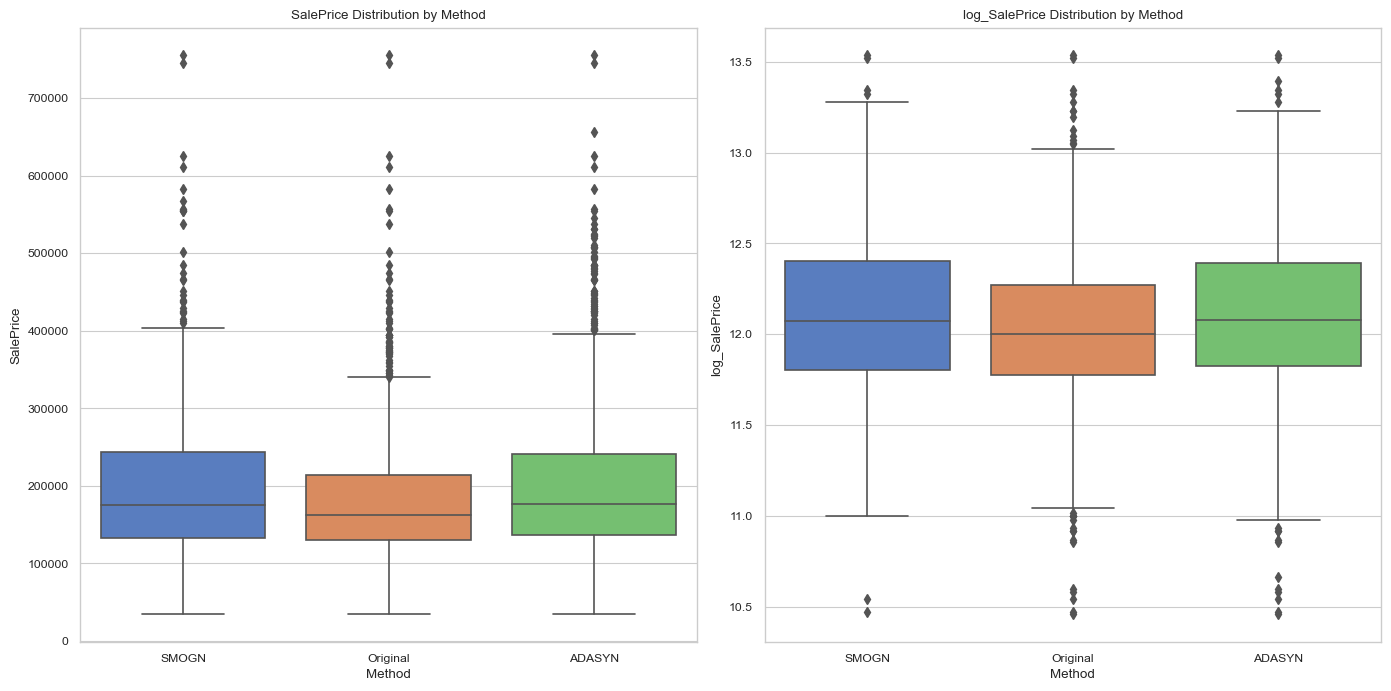

In [44]:
ax = housing_smogn['SalePrice'].plot(kind='kde', xlim=(0, 1000000), xlabel='SalePrice', ylabel='Density', title='SalePrice Distribution', label='SMOTED', legend=True)
train_data_filtrado['SalePrice'].plot(kind='kde', ax=ax, sharex=True, label='Original', legend=True)
adasyn_resampled['SalePrice'].plot(kind='kde', ax=ax, sharex=True, label='ADASYN', legend=True)

smogn_df = housing_smogn[['SalePrice', 'log_SalePrice']].copy()
smogn_df['Method'] = 'SMOGN'

original_df = train_data_filtrado[['SalePrice', 'log_SalePrice']].copy()
original_df['Method'] = 'Original'

adasyn_df = adasyn_resampled[['SalePrice', 'log_SalePrice']].copy()
adasyn_df['Method'] = 'ADASYN'

# Concatenar los DataFrames
combined_df = pd.concat([smogn_df, original_df, adasyn_df])

# Crear los boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.boxplot(x='Method', y='SalePrice', data=combined_df, ax=axes[0])
axes[0].set_title('SalePrice Distribution by Method')

sns.boxplot(x='Method', y='log_SalePrice', data=combined_df, ax=axes[1])
axes[1].set_title('log_SalePrice Distribution by Method')

plt.tight_layout()
plt.show()


### Observaciones:
- Por un lado, hacer el sobremuestreo mejora la distribucion de precios y casas hacia casas mas altas de una forma suavizada. 
- Por otro lado, se observa en los boxplots como la transformación logaritmica (tipicamente usada para corregerir el right skew) mejora la distribucion de los precios comprimiendo la distribución, normalizandola y reduiciendo outliers.

## Generamos una función para detectar las features con low_variance

In [45]:
from scipy import stats

def detect_low_variance(df, threshold_continuous=0.1, threshold_discrete=0.1):
    low_variance_columns = []
    
    for column in df.columns:
        unique_values = df[column].unique()
        n_unique = len(unique_values)
        
        if n_unique == 2:
            # Binary variable (Bernoulli)
            p = df[column].mean()
            variance = p * (1 - p)
            if variance < threshold_discrete:
                low_variance_columns.append(column)
        elif pd.api.types.is_numeric_dtype(df[column]):
            if n_unique <= 10:  # Arbitrary cutoff for "small" number of unique values
                # Treat as discrete (potentially Binomial)
                counts = df[column].value_counts()
                n = df[column].count()  # total number of trials
                p = counts.index[counts.argmax()] / n  # estimate p from most common value
                variance = n * p * (1 - p)
                
                # Handle the case where n * p is zero
                if n * p > 0:
                    normalized_variance = variance / (n * p)**2  # normalize by squared mean
                    if normalized_variance < threshold_discrete:
                        low_variance_columns.append(column)
                elif variance == 0:
                    # If both variance and mean are zero, consider it as low variance
                    low_variance_columns.append(column)
            else:
                # Treat as continuous
                variance = df[column].var()
                mean = df[column].mean()
                if mean != 0:
                    normalized_variance = variance / (mean ** 2)
                    if column == 'log_SalePrice':
                        print(f'Columna: {column}, Variance: {variance}, Mean: {mean}, Normalized Variance: {normalized_variance}')
                    if normalized_variance < threshold_continuous:
                        low_variance_columns.append(column)
                elif variance == 0:
                    low_variance_columns.append(column)
        else:
            # Categorical variable
            entropy = stats.entropy(df[column].value_counts())
            max_entropy = np.log(n_unique)
            if max_entropy != 0:
                normalized_entropy = entropy / max_entropy
                if 1 - normalized_entropy < threshold_discrete:
                    low_variance_columns.append(column)
    
    return low_variance_columns

In [46]:
low_variance_cols_original = detect_low_variance(train_data_filtrado.drop(columns=['log_SalePrice', 'SalePrice']))
low_variance_cols_adasyn = detect_low_variance(adasyn_resampled.drop(columns=['log_SalePrice', 'SalePrice']))
low_variance_cols_smogn = detect_low_variance(housing_smogn.drop(columns=['log_SalePrice', 'SalePrice']))
print("Original columns with low variance:", low_variance_cols_original)
print("ADASYN columns with low variance:", low_variance_cols_adasyn)
print("SMOTED columns with low variance:", low_variance_cols_smogn)

# Features que aparecen como low variance en los 3 casos
low_variance_cols = set(low_variance_cols_original) & set(low_variance_cols_adasyn) & set(low_variance_cols_smogn)
print("Columns with low variance in all cases:", low_variance_cols, "with length: ", len(low_variance_cols))

Original columns with low variance: ['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'PoolArea', 'MSZoning_fv', 'MSZoning_rh', 'MSZoning_rm', 'Street_pave', 'Street_nan', 'LotShape_ir2', 'LotShape_ir3', 'LotShape_nan', 'LandContour_hls', 'LandContour_low', 'LandContour_lvl', 'LandContour_nan', 'Utilities_nosewa', 'Utilities_nan', 'LotConfig_culdsac', 'LotConfig_fr2', 'LotConfig_fr3', 'LotConfig_nan', 'LandSlope_mod', 'LandSlope_sev', 'LandSlope_nan', 'BldgType_2fmcon', 'BldgType_duplex', 'BldgType_twnhs', 'BldgType_twnhse', 'BldgType_nan', 'MasVnrType_stone', 'MasVnrType_nan', 'ExterQual_fa', 'ExterQual_nan', 'ExterCond_fa', 'ExterCond_gd', 'ExterCond_po', 'ExterCond_nan', 'BsmtQual_fa', 'BsmtQual_nan', 'BsmtCond_gd', 'BsmtCond_po', 'BsmtCond_ta', 'BsmtCond_nan', 'BsmtExposure_gd', 'BsmtExposure_mn', 'BsmtExposure_nan', 'HeatingQC_fa', 'HeatingQC_po', 'HeatingQC_nan', 'CentralAir_y', 'CentralAir_nan', 'Electrical_fusef', 'Electrical_fusep', 'Electrical_mix', '

Tras realizar sobremuestreo y evaluar que variables se comportan con baja varianza, se ha decidido eliminar las siguientes variables que aparecen en los 3 casos por lo que suponemos que evidentemente tendrán poca varianza.

In [47]:
# Drop low var 
train_data_filtrado.drop(low_variance_cols, axis=1, inplace=True)
adasyn_resampled.drop(low_variance_cols, axis=1, inplace=True)
housing_smogn.drop(low_variance_cols, axis=1, inplace=True)

In [58]:
train_data_filtrado.isna().sum()

MSSubClass       4
LotFrontage      4
LotArea          4
Neighborhood     0
Condition1       0
                ..
YrSold_2007.0    0
YrSold_2008.0    0
YrSold_2009.0    0
YrSold_2010.0    0
log_SalePrice    4
Length: 105, dtype: int64

In [59]:
# Eliminamos los 4 nans 
train_data_filtrado.dropna(inplace=True)
adasyn_resampled.dropna(inplace=True)
housing_smogn.dropna(inplace=True)

## Feature transformation
Apply transformations to continuos and discrete features so they adapt to the model we want to use.

For example, if a feature has a log relationship with the target, we can apply a log transformation to it to normalize the distribution of the feature.

The main reason is that linear models assume that the features are normally distributed, so if we apply a transformation to the features that makes them normally distributed, the model will perform better.
This also applies to more complex models.

### Why Use Data Fitting for Feature Transformation?

Feature transformation and data fitting are essential steps in machine learning to improve the performance of models. Here's a simplified explanation of why we do this:

1. **Adapt Features to the Model**:
    - Different models have different assumptions about how data should be distributed. For instance, linear models assume that the relationship between the input features and the target variable is linear. If the actual relationship is not linear, transforming the features can help match this assumption.

2. **Improve Model Performance**:
    - By fitting the data to different models (linear, exponential, logarithmic, etc.), we can identify the best transformation for the features. This helps the model to better understand and capture the patterns in the data, leading to more accurate predictions.

3. **Normalize Data**:
    - Some features may have skewed distributions or outliers. Transforming these features (e.g., using log transformation for positively skewed data) can help normalize their distribution, making the model training more stable and efficient.

4. **Linearize Relationships**:
    - If a feature has a non-linear relationship with the target variable, applying an appropriate transformation can linearize this relationship. This makes it easier for linear models to fit the data effectively.

5. **Stabilize Variance**:
    - In some cases, the variance of a feature might change across its range (heteroscedasticity). Transformations can help stabilize the variance, which improves model performance.


In [283]:
import numpy as np
from scipy.optimize import curve_fit
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Definir diferentes modelos
def linear_model(x, a, b):
    return a * x + b

def logarithmic_model(x, a, b):
    return a * np.log(x+1) + b

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

def power_model(x, a, b):
    return a * x**b

def logistic_model(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

def sqrt_model(x, a, b):
    return a * np.sqrt(x) + b

def poly_model(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def trigonometric_model(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Modelo para variables discretas
def discrete_model(x, *params):
    return np.select([x == i for i in range(len(params))], params)

# Ajustar modelos
def fit_model(x, y, model, p0=None):
    try:
        popt, pcov = curve_fit(model, x, y, p0=p0, maxfev=10000)
        return popt, pcov
    except RuntimeError as e:
        errors_logger.warning(f"No se pudo ajustar el modelo {model.__name__}: {str(e)}")
        return None, None

# Calcular R-cuadrado
def calculate_r_squared(x, y, model, popt):
    residuals = y - model(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# Función principal para ajustar y evaluar modelos
def fit_and_evaluate_models(x, y, is_discrete=False):
    app_logger.info("Iniciando el ajuste y evaluación de modelos")
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    if is_discrete:
        unique_values = np.unique(x)
        if len(unique_values) <= 20:
            app_logger.info("Ajustando modelo discreto")
            popt, pcov = fit_model(x_train, y_train, discrete_model, p0=np.ones(len(unique_values)))
            if popt is not None:
                r_squared = calculate_r_squared(x_test, y_test, discrete_model, popt)
                app_logger.info(f"R-cuadrado para modelo discreto: {r_squared}")
                return {"model": "discrete", "params": popt, "r_squared": r_squared}
        else:
            app_logger.warning("Demasiados valores únicos para un modelo discreto")
    
    models = [
        (linear_model, "Lineal"),
        (logarithmic_model, "Logarítmico"),
        (quadratic_model, "Cuadrático"),
        (sqrt_model, "Raíz Cuadrada"),
        (power_model, "Potencia"),
        (logistic_model, "Logístico"),
        (poly_model, "Polinómico"),
        (trigonometric_model, "Trigonométrico")
    ]
    
    best_model = None
    best_r_squared = -np.inf
    
    for model_func, model_name in models:
        app_logger.info(f"Ajustando modelo {model_name}")
        popt, pcov = fit_model(x_train, y_train, model_func)
        if popt is not None:
            r_squared = calculate_r_squared(x_test, y_test, model_func, popt)
            app_logger.info(f"R-cuadrado para modelo {model_name}: {r_squared}")
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_model = {"model": model_name, "params": popt, "r_squared": r_squared}
    
    if best_model:
        app_logger.info(f"El mejor modelo es {best_model['model']} con R-cuadrado {best_model['r_squared']}")
    else:
        app_logger.warning("No se pudo ajustar ningún modelo")
    
    return best_model

# Crear un DataFrame vacío para almacenar los resultados
results_df = pd.DataFrame(columns=['DataFrame', 'Variable', 'Best Model', 'R-squared'])


def store_results(dataframe_name, variable, best_model, r_squared, params):
    global results_df
    # Crear un DataFrame temporal con la nueva fila
    new_row = pd.DataFrame({
        'DataFrame': [dataframe_name],
        'Variable': [variable],
        'Best Model': [best_model],
        'R-squared': [r_squared],
        'Params': [params]
    })
    
    # Concatenar el DataFrame temporal con el DataFrame global
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Usamos la función para ajustar y evaluar modelos
dataframes = {
    "Original": train_data_filtrado,
    "adasyn": adasyn_resampled,
    "smote": housing_smogn,
    "log_sale_Original": train_data_filtrado,
    "log_sale_adasyn": adasyn_resampled,
    "log_sale_smote": housing_smogn
}

for df_name, df in dataframes.items():
    print(f"Evaluando modelos para el dataframe: {df_name}")
    targets = ['log_SalePrice', 'SalePrice']
    if 'log' in df_name:
        target = 0
    else:
        target = 1
    for col in df.columns:
        if col not in targets:
            best_model = fit_and_evaluate_models(df[col], df[targets[target]])
            if best_model and best_model['r_squared'] > 0.3:
                print(f'El mejor modelo para {col} en {df_name} es {best_model["model"]} con R-cuadrado {best_model["r_squared"]}')
                # Almacenar los resultados
                store_results(df_name, col, best_model['model'], best_model['r_squared'], best_model['params'])


Evaluando modelos para el dataframe: Original
El mejor modelo para OverallQual en Original es Polinómico con R-cuadrado 0.7047721389566968
El mejor modelo para TotalBsmtSF en Original es Polinómico con R-cuadrado 0.41161403104388317
El mejor modelo para 1stFlrSF en Original es Lineal con R-cuadrado 0.3554262726817655
El mejor modelo para GrLivArea en Original es Potencia con R-cuadrado 0.4983129871930576
El mejor modelo para GarageArea en Original es Cuadrático con R-cuadrado 0.4168596303416545
Evaluando modelos para el dataframe: adasyn
El mejor modelo para OverallQual en adasyn es Polinómico con R-cuadrado 0.5719457328415843
El mejor modelo para TotalBsmtSF en adasyn es Polinómico con R-cuadrado 0.4789283738026544
El mejor modelo para 1stFlrSF en adasyn es Polinómico con R-cuadrado 0.4864762538587606
El mejor modelo para GrLivArea en adasyn es Polinómico con R-cuadrado 0.575976307502721
El mejor modelo para TotRmsAbvGrd en adasyn es Polinómico con R-cuadrado 0.33165717831106567
El me

In [284]:
# Definir las métricas que queremos calcular
metricas = ['mean', 'std', 'max']

# Calcular las métricas para 'DataFrame' y 'R-squared'
resultados_dataframe = results_df.groupby('DataFrame')['R-squared'].agg(metricas)

# Calcular el máximo R-squared para 'Variable' y 'Best Model'
max_r_squared = {
    'Variable': results_df.groupby('Variable')['R-squared'].max(),
    'Best Model': results_df.groupby('Best Model')['R-squared'].max()
}

# Combinar todos los resultados en un solo DataFrame
resultados_finales = pd.concat([resultados_dataframe] + [pd.Series(v, name=k) for k, v in max_r_squared.items()], axis=1)

# Mostrar los resultados
print(resultados_finales)

                       mean       std       max  Variable  Best Model
Original           0.477397  0.136936  0.704772       NaN         NaN
adasyn             0.467694  0.102882  0.575976       NaN         NaN
log_sale_Original  0.453439  0.133051  0.677399       NaN         NaN
log_sale_adasyn    0.492295  0.099409  0.612069       NaN         NaN
log_sale_smote     0.456947  0.145950  0.726679       NaN         NaN
smote              0.475065  0.125861  0.694281       NaN         NaN
1stFlrSF                NaN       NaN       NaN  0.498703         NaN
BsmtFinSF1              NaN       NaN       NaN  0.414138         NaN
GarageArea              NaN       NaN       NaN  0.439190         NaN
GrLivArea               NaN       NaN       NaN  0.612069         NaN
MasVnrArea              NaN       NaN       NaN  0.322781         NaN
OverallQual             NaN       NaN       NaN  0.726679         NaN
TotRmsAbvGrd            NaN       NaN       NaN  0.348387         NaN
TotalBsmtSF         

In [285]:
# Datasets:
Original_df = train_data_filtrado.drop(columns=['log_SalePrice'])
adasyn_df = adasyn_resampled.drop(columns=['log_SalePrice'])
smote_df = housing_smogn.drop(columns=['log_SalePrice'])
log_sale_Original = train_data_filtrado.drop(columns=['SalePrice'])
log_sale_adasyn = adasyn_resampled.drop(columns=['SalePrice'])
log_sale_smote = housing_smogn.drop(columns=['SalePrice'])

In [286]:
# Definir las funciones para aplicar las transformaciones
def apply_transformation(df, variable, model_name, params):
    if model_name == "Lineal":
        a, b = params
        df[f'{variable}_lineal'] = linear_model(df[variable], a, b)
    elif model_name == "Logarítmico":
        a, b = params
        df[f'{variable}_logaritmico'] = logarithmic_model(df[variable], a, b)
    elif model_name == "Cuadrático":
        a, b, c = params
        df[f'{variable}_cuadratico'] = quadratic_model(df[variable], a, b, c)
    elif model_name == "Potencia":
        a, b = params
        df[f'{variable}_potencia'] = power_model(df[variable], a, b)
    elif model_name == "Logístico":
        a, b, c = params
        df[f'{variable}_logistico'] = logistic_model(df[variable], a, b, c)
    elif model_name == "Raíz Cuadrada":
        a, b = params
        df[f'{variable}_raiz_cuadrada'] = sqrt_model(df[variable], a, b)
    elif model_name == "Polinómico":
        a, b, c, d = params
        df[f'{variable}_polinomico'] = poly_model(df[variable], a, b, c, d)
    elif model_name == "Trigonométrico":
        a, b, c, d = params
        df[f'{variable}_trigonometrico'] = trigonometric_model(df[variable], a, b, c, d)
    elif model_name == "discrete":
        # Para el modelo discreto, se asume que `params` contiene los valores de los parámetros directamente
        df[f'{variable}_discreto'] = discrete_model(df[variable], *params)
    else:
        raise ValueError(f"Modelo desconocido: {model_name}")

# Aplicar las transformaciones a los DataFrames correspondientes
def apply_transformations(results_df, dataframes):
    for _, row in results_df.iterrows():
        df_name = row['DataFrame']
        variable = row['Variable']
        model_name = row['Best Model']
        params = row['Params']

        if df_name in dataframes:
            df = dataframes[df_name]
            apply_transformation(df, variable, model_name, params)
            dataframes[df_name] = df
            print(f"Transformación aplicada a {df_name} para la variable {variable} con el modelo {model_name}")
    return dataframes


# Crear un diccionario con los DataFrames que se van a transformar
dataframes = {
    "Original": Original_df,
    "adasyn": adasyn_df,
    "smote": smote_df,
    "log_sale_Original": log_sale_Original,
    "log_sale_adasyn": log_sale_adasyn,
    "log_sale_smote": log_sale_smote
}

# Aplicar las transformaciones
dataframes = apply_transformations(results_df, dataframes)


Transformación aplicada a Original para la variable OverallQual con el modelo Polinómico
Transformación aplicada a Original para la variable TotalBsmtSF con el modelo Polinómico
Transformación aplicada a Original para la variable 1stFlrSF con el modelo Lineal
Transformación aplicada a Original para la variable GrLivArea con el modelo Potencia
Transformación aplicada a Original para la variable GarageArea con el modelo Cuadrático
Transformación aplicada a adasyn para la variable OverallQual con el modelo Polinómico
Transformación aplicada a adasyn para la variable TotalBsmtSF con el modelo Polinómico
Transformación aplicada a adasyn para la variable 1stFlrSF con el modelo Polinómico
Transformación aplicada a adasyn para la variable GrLivArea con el modelo Polinómico
Transformación aplicada a adasyn para la variable TotRmsAbvGrd con el modelo Polinómico
Transformación aplicada a adasyn para la variable GarageArea con el modelo Polinómico
Transformación aplicada a smote para la variable O

In [287]:
dataframes.keys()

dict_keys(['Original', 'adasyn', 'smote', 'log_sale_Original', 'log_sale_adasyn', 'log_sale_smote'])

In [288]:
# Printamos las dimensiones de los dataframes:
for name, df in dataframes.items():
    print(f"Dimensión del DataFrame {name}: {df.shape}")

Dimensión del DataFrame Original: (1453, 109)
Dimensión del DataFrame adasyn: (1851, 110)
Dimensión del DataFrame smote: (1239, 112)
Dimensión del DataFrame log_sale_Original: (1453, 110)
Dimensión del DataFrame log_sale_adasyn: (1851, 110)
Dimensión del DataFrame log_sale_smote: (1239, 112)


## Feature Selection Statiscal Methods 

In [289]:
import pandas as pd
import numpy as np
from minepy import MINE
import dcor
from scipy.stats import gamma
from scipy import stats
import xicorpy
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

### Selection based on **Correlation**:

In this section, we will analyze the correlation between the dataset features and the sale price (SalePrice). Correlation is a statistical measure that indicates the strength and direction of a linear relationship between two variables.

We will use different correlation methods depending on the nature of the data:

1. **Pearson Correlation**: Used when both variables are numerical and follow a normal distribution. It measures the linear relationship between two variables.
2. **Spearman Correlation**: Used when the variables are numerical but do not follow a normal distribution. It measures the monotonic relationship between two variables.
3. **Kendall Correlation**: Used when the relationship between the variables is not necessarily linear or monotonic. It measures the concordance between two variables.

The `calcular_correlacion` function will automatically determine the most appropriate correlation method for each pair of variables.


In [189]:
def calcular_correlacion(x, y):
    # Check if both variables are numeric
    if not (np.issubdtype(x.dtype, np.number) and np.issubdtype(y.dtype, np.number)):
        raise ValueError("Both variables must be numeric")
    
    # Check normality of the variables
    _, p_value_x = stats.normaltest(x)
    _, p_value_y = stats.normaltest(y)
    
    # If both variables are normally distributed, use Pearson correlation
    if p_value_x > 0.05 and p_value_y > 0.05:
        return stats.pearsonr(x, y)[0]
    
    # Ensure x and y are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Check monotonicity of the relationship
    sorted_indices = np.argsort(x)
    sorted_y = y[sorted_indices]
    is_monotonic = np.all(np.diff(sorted_y) >= 0) or np.all(np.diff(sorted_y) <= 0)
    
    # Use Spearman if the relationship is monotonic, otherwise Kendall
    if is_monotonic:
        return stats.spearmanr(x, y)[0]
    else:
        return stats.kendalltau(x, y)[0]

In [190]:
def analizar_correlacion(train_data_filtrado, target, umbral):
    app_logger.info("Analizando la correlación entre las características...")
    
    # Seleccionar solo las columnas numéricas
    datos_numericos = train_data_filtrado.select_dtypes(include=[np.number])
    
    # Calcular las correlaciones con 'SalePrice' usando la función personalizada
    correlaciones_saleprice = {}
    for columna in datos_numericos.columns:
        if columna != target:
            try:
                correlacion = calcular_correlacion(datos_numericos[columna], datos_numericos[target])
                if not np.isnan(correlacion):
                    correlaciones_saleprice[columna] = correlacion
            except ValueError as e:
                app_logger.warning(f"No se pudo calcular la correlación para {columna}: {str(e)}")
    
    # Ordenar las correlaciones
    top_correlaciones_saleprice = sorted(correlaciones_saleprice.items(), key=lambda item: abs(item[1]), reverse=True)[:umbral]
    top_features = [item[0] for item in top_correlaciones_saleprice]
    # Imprimir las correlaciones
    app_logger.info(f"Las 10 características más correlacionadas con SalePrice son: {top_correlaciones_saleprice}")
    
    return top_correlaciones_saleprice, top_features

In [290]:
# Calcular la correlación
umbral = 10

selected_features_corr = {}

for nombre, df in dataframes.items():
    if 'log' in nombre:
        correlaciones_saleprice, top_correlaciones_saleprice = analizar_correlacion(df, 'log_SalePrice', umbral)
        selected_features_corr[nombre] = top_correlaciones_saleprice
    else:
        correlaciones_saleprice, top_correlaciones_saleprice = analizar_correlacion(df, 'SalePrice', umbral)
        selected_features_corr[nombre] = top_correlaciones_saleprice
    print(f'El top {umbral} de correlaciones de SalePrice en {nombre} es: {top_correlaciones_saleprice}')

El top 10 de correlaciones de SalePrice en Original es: ['OverallQual', 'OverallQual_polinomico', 'GrLivArea', 'GrLivArea_potencia', 'GarageArea', 'GarageArea_cuadratico', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF', '1stFlrSF_lineal']
El top 10 de correlaciones de SalePrice en adasyn es: ['OverallQual', 'OverallQual_polinomico', 'GrLivArea_polinomico', 'GrLivArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', 'GarageArea_polinomico', '1stFlrSF_polinomico', 'GarageArea', '1stFlrSF']
El top 10 de correlaciones de SalePrice en smote es: ['OverallQual', 'OverallQual_cuadratico', 'GrLivArea_polinomico', 'GrLivArea', 'GarageArea_polinomico', 'GarageArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF_polinomico', '1stFlrSF']
El top 10 de correlaciones de SalePrice en log_sale_Original es: ['OverallQual', 'OverallQual_lineal', 'GrLivArea', 'GrLivArea_logaritmico', 'GarageArea_polinomico', 'GarageArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF', '1stFlrSF_logaritmico']
El t

### Selection based on **HSIC** (Hilbert-Schmidt Independence Criterion)

HSIC is a measure of statistical dependence between random variables. It has several advantages over other correlation measures:

1. It can detect non-linear relationships between variables.
2. It is capable of handling variables of different types (continuous, categorical, etc.).
3. It is robust against outliers and monotonic transformations of the variables.

HSIC is based on the theory of reproducing kernel Hilbert spaces (RKHS). It measures the dependence between two variables X and Y by calculating the Hilbert-Schmidt norm of the cross-covariance between the representations of the variables in their respective RKHS.

An HSIC value close to 0 indicates independence, while higher values indicate a greater dependence between the variables.

We will use HSIC to select the most relevant features for predicting the sale price (SalePrice) in our dataset.

In [81]:
from scipy.stats import gamma
def hsic_gam(X, Y, alph=0.001):
    n = X.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    Kc = H @ X @ X.T @ H
    Lc = H @ Y @ Y.T @ H
    testStat = np.trace(Kc @ Lc)
    varHSIC = (Kc * Lc).sum() / (n * (n - 1))
    K = varHSIC * (n - 1) * (n - 2) * (n - 3)
    c = np.sqrt(K) / n
    v = varHSIC * (2 * (n - 2)) / (n * (n - 1))
    alph = 1 - c / (n * (n - 1)) # alpha determina el nivel de confianza
    thresh = gamma.ppf(1 - alph, v / 2, scale=2 / v)
    return testStat, thresh

In [83]:
def realizar_prueba_hsic(df, target):
    app_logger.info("Realizando prueba de la función HSIC...")
    caracteristicas_numericas = df.select_dtypes(include=[np.number]).drop(columns=[target])
    Y = df[target].values.reshape(-1, 1)
    resultados = {}
    for caracteristica in caracteristicas_numericas:
        X = df[caracteristica].values.reshape(-1, 1)
        estadistico_prueba, umbral = hsic_gam(X, Y)
        resultados[caracteristica] = {
            'estadistico': estadistico_prueba,
            'umbral': umbral,
            'dependiente': estadistico_prueba > umbral
        }
        if resultados[caracteristica]['dependiente']:
            app_logger.info(f"La variable {caracteristica} y el precio de venta son dependientes según la prueba HSIC.")
        else:
            app_logger.info(f"No se puede rechazar la hipótesis de independencia entre {caracteristica} y el precio de venta.")
    
    caracteristicas_dependientes = {k: v for k, v in resultados.items() if v['dependiente']}
    app_logger.info(f"Se encontraron {len(caracteristicas_dependientes)} características dependientes del precio de venta según la prueba HSIC.")
    return resultados, caracteristicas_dependientes

### No la ejecuto por que mme esta devolviendo que practicamente todas son dependientes de la target, quizas es que no entiendo del todo como funciona HSIC. Prefiero no inventarmelo y no meter esta info en el feature selection

In [84]:
# Prueba HSIC
# for nombre, df in dataframes.items():
#     if 'log' in nombre:
#         resultados, caracteristicas_dependientes = realizar_prueba_hsic(df, 'log_SalePrice')
#     else:
#         resultados, caracteristicas_dependientes = realizar_prueba_hsic(df, 'SalePrice')
#     print(f'Features con dependencia de SalePrice en {nombre} es: {caracteristicas_dependientes.keys()}')

Features con dependencia de SalePrice en Original es: dict_keys(['MSSubClass', 'Condition1', 'Condition2', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'BedroomAbvGr', 'Functional', 'FireplaceQu', 'GarageType', 'PoolArea', 'MoSold', 'SaleType', 'SaleCondition', 'MSZoning_fv', 'MSZoning_rh', 'MSZoning_rl', 'MSZoning_rm', 'LotShape_ir2', 'LotShape_reg', 'LandContour_low', 'LandContour_lvl', 'LotConfig_culdsac', 'LotConfig_fr2', 'LotConfig_inside', 'LandSlope_mod', 'BldgType_2fmcon', 'BldgType_duplex', 'BldgType_twnhse', 'MasVnrType_brkface', 'MasVnrType_none', 'MasVnrType_stone', 'ExterQual_gd', 'ExterQual_ta', 'ExterCond_fa', 'ExterCond_gd', 'ExterCond_po', 'ExterCond_ta', 'BsmtQual_fa', 'BsmtQual_gd', 'BsmtQual_ta', 'BsmtCond_gd', 'BsmtExposure_gd', 'BsmtExposure_mn', 'BsmtExposure_no', 'HeatingQC_fa', 'HeatingQC_gd', 'HeatingQC_ta', 'Electrical_fusef', 'Electrical_sbrkr', 'BsmtFullBath_1.0'

### Selection Based on **MIC** (Maximal Information Criterion)

MIC (Maximal Information Criterion) is a measure that captures both linear and non-linear relationships between variables. Unlike Pearson's correlation, which only detects linear relationships, MIC can identify any type of relationship.

A MIC value close to 1 indicates a strong dependence between the variables, while a value close to 0 indicates independence.

**Advantages of MIC:**
1. **Flexibility:** MIC can detect a wide range of relationships, not limited to linear associations.
2. **Robustness:** It is less sensitive to noise in the data compared to traditional correlation measures.
3. **Comprehensiveness:** It provides a more complete picture of the dependency structure between variables.

**Applications of MIC:**
1. **Feature Selection:** In machine learning, MIC can be used to select features that have significant relationships with the target variable, improving model performance.
2. **Data Analysis:** MIC helps in exploratory data analysis by uncovering hidden patterns and relationships in the data.
3. **Bioinformatics:** It is used to identify complex relationships between genetic markers and traits in genomics studies.

**Calculation of MIC:**
The calculation of MIC involves:
1. **Discretization:** Dividing the data into grids of different resolutions.
2. **Evaluation:** Measuring the mutual information for each grid.
3. **Maximization:** Identifying the maximum mutual information across all grids.

**Limitations of MIC:**
1. **Computational Complexity:** The computation of MIC can be intensive, especially for large datasets.
2. **Parameter Sensitivity:** The performance of MIC can be sensitive to the choice of parameters, such as the grid resolution.

**Conclusion:**
MIC is a powerful tool for detecting and quantifying relationships between variables, making it valuable for various fields, including statistics, machine learning, and bioinformatics. Its ability to uncover both linear and non-linear dependencies provides a significant advantage over traditional correlation measures.

In [291]:
from minepy import MINE
def calcular_mic(x, y):
    mine = MINE()
    mine.compute_score(x, y)
    return mine.mic()

In [292]:
def analizar_mic(train_data_filtrado, target, umbral):
    app_logger.info("Realizando prueba de la función HSIC...")
    caracteristicas_numericas = train_data_filtrado.select_dtypes(include=[np.number]).drop(columns=[target]).columns
    Y = train_data_filtrado[target].values
    X = train_data_filtrado[caracteristicas_numericas].values
    resultados = {}
    for i, caracteristica in enumerate(caracteristicas_numericas):
        mic_valor = calcular_mic(X[:, i], Y)
        resultados[caracteristica] = mic_valor
    app_logger.info(f"Resultados de la prueba de MIC para {len(caracteristicas_numericas)} características: {resultados}")

    #Seleccionar el top 10 características con mayor MIC
    caracteristicas_seleccionadas = sorted(resultados, key=resultados.get, reverse=True)[:umbral]
    app_logger.info(f"Se seleccionaron {len(caracteristicas_seleccionadas)} características con mayor MIC: {caracteristicas_seleccionadas}")

    return resultados, caracteristicas_seleccionadas

In [293]:
# Calcular el MIC
umbral = 10

selected_features_mic = {}

for nombre, df in dataframes.items():
    if 'log' in nombre:
        resultados, caracteristicas_dependientes = analizar_mic(df, 'log_SalePrice', umbral)
        selected_features_mic[nombre] = caracteristicas_dependientes
    else:
        resultados, caracteristicas_dependientes = analizar_mic(df, 'SalePrice', umbral)
        selected_features_mic[nombre] = caracteristicas_dependientes
    print(f'Features con dependencia de SalePrice en {nombre} es: {caracteristicas_dependientes}')

Features con dependencia de SalePrice en Original es: ['OverallQual', 'OverallQual_polinomico', 'GrLivArea', 'GrLivArea_potencia', 'Neighborhood', 'GarageArea', 'GarageArea_cuadratico', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', 'Foundation']
Features con dependencia de SalePrice en adasyn es: ['OverallQual', 'OverallQual_polinomico', 'GrLivArea', 'GrLivArea_polinomico', 'Neighborhood', 'GarageArea', 'GarageArea_polinomico', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF_polinomico']
Features con dependencia de SalePrice en smote es: ['OverallQual', 'OverallQual_cuadratico', 'GrLivArea_polinomico', 'GrLivArea', 'GarageArea_polinomico', 'GarageArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF', '1stFlrSF_polinomico']
Features con dependencia de SalePrice en log_sale_Original es: ['OverallQual', 'OverallQual_lineal', 'GrLivArea', 'GrLivArea_logaritmico', 'Neighborhood', 'GarageArea_polinomico', 'GarageArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', 'Foundation']
Features con de

### Selection Based on **DCOR** (Distance Correlation)

**DCOR** (Distance Correlation) is a statistical measure designed to capture both linear and non-linear dependencies between variables. It is particularly useful when the relationship between variables is complex and cannot be fully described by traditional measures like Pearson’s correlation.

**Key Features of DCOR:**
1. **Non-Linearity Detection:** Unlike Pearson's correlation, which only captures linear relationships, DCOR can detect non-linear associations.
2. **Independence Measurement:** DCOR measures the degree of dependence between variables, with a value of zero indicating complete independence.

**How DCOR Works:**
1. **Distance Matrix Calculation:** For each variable, compute the distance matrix, which captures pairwise distances between data points.
2. **Centering Distance Matrices:** Center the distance matrices to remove the effect of the mean distance.
3. **Compute Distance Correlation:** Calculate the distance correlation by evaluating how well the distance matrices of the two variables align.

**Advantages of DCOR:**
1. **Comprehensive Dependence Measurement:** DCOR can detect any form of statistical dependence between variables, whether linear or non-linear.
2. **Robustness:** It is less sensitive to outliers compared to some other correlation measures.

**Applications of DCOR:**
1. **Feature Selection:** In machine learning, DCOR can be used to identify features that have significant relationships with the target variable, improving model performance.
2. **Data Analysis:** DCOR is valuable in exploratory data analysis for uncovering complex dependencies in datasets.
3. **Bioinformatics:** It is used to find intricate relationships between genetic markers and biological traits.

**Calculation of DCOR:**
1. **Compute Distance Matrices:** For each variable, calculate the distance between each pair of observations.
2. **Center the Matrices:** Adjust the distance matrices to account for the mean distance, making them centered.
3. **Evaluate Correlation:** Calculate the distance correlation by comparing how well the centered distance matrices align.

**Limitations of DCOR:**
1. **Computational Complexity:** The calculation of distance correlation can be computationally intensive, especially for large datasets.
2. **Interpretability:** While DCOR provides a measure of dependence, interpreting the specific nature of the relationship can be more challenging than with linear measures.

**Conclusion:**
DCOR is a robust and flexible tool for measuring the strength of dependency between variables. Its ability to detect both linear and non-linear relationships makes it a valuable measure in various fields, including statistics, data science, and bioinformatics. By capturing a broader spectrum of dependencies than traditional correlation measures, DCOR enhances the analysis of complex datasets.

In [98]:
import dcor
def calcular_dcor(x, y):
    return dcor.distance_correlation(x, y)

In [99]:
def analizar_dcor(train_data_filtrado, target, umbral):
    app_logger.info("Realizando prueba de la función DCOR...")
    caracteristicas_numericas = train_data_filtrado.select_dtypes(include=[np.number]).drop(columns=[target])
    Y = train_data_filtrado[target].values
    X = train_data_filtrado[caracteristicas_numericas.columns].values
    resultados = {}
    for i, caracteristica in enumerate(caracteristicas_numericas):
        dcor_valor = calcular_dcor(X[:, i], Y)
        resultados[caracteristica] = dcor_valor
    app_logger.info(f"Resultados de la prueba de DCOR para {len(caracteristicas_numericas)} características: {resultados}")
    
    # Top umbral
    caracteristicas_seleccionadas = sorted(resultados, key=resultados.get, reverse=True)[:umbral]
    app_logger.info(f"Se seleccionaron {len(caracteristicas_seleccionadas)} características con mayor DCOR: {caracteristicas_seleccionadas}")
    return resultados, caracteristicas_seleccionadas

In [294]:
# Calcular el DCOR
umbral = 10

selected_features_dcor = {}

for nombre, df in dataframes.items():
    if 'log' in nombre:
        resultados, caracteristicas_dependientes = analizar_dcor(df, 'log_SalePrice', umbral)
        selected_features_dcor[nombre] = caracteristicas_dependientes
    else:
        resultados, caracteristicas_dependientes = analizar_dcor(df, 'SalePrice', umbral)
        selected_features_dcor[nombre] = caracteristicas_dependientes
    print(f'Features con dependencia de SalePrice en {nombre} es: {caracteristicas_dependientes}')

Features con dependencia de SalePrice en Original es: ['OverallQual_polinomico', 'OverallQual', 'GrLivArea_potencia', 'GrLivArea', 'GarageArea_cuadratico', 'GarageArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF_lineal', '1stFlrSF']
Features con dependencia de SalePrice en adasyn es: ['GrLivArea_polinomico', 'OverallQual_polinomico', 'OverallQual', 'GrLivArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF_polinomico', '1stFlrSF', 'GarageArea_polinomico', 'GarageArea']
Features con dependencia de SalePrice en smote es: ['OverallQual_cuadratico', 'OverallQual', 'GrLivArea_polinomico', 'GrLivArea', 'GarageArea_polinomico', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', 'GarageArea', '1stFlrSF_polinomico', '1stFlrSF']
Features con dependencia de SalePrice en log_sale_Original es: ['OverallQual', 'OverallQual_lineal', 'GrLivArea_logaritmico', 'GrLivArea', 'GarageArea_polinomico', 'GarageArea', 'TotalBsmtSF_polinomico', 'TotalBsmtSF', '1stFlrSF', '1stFlrSF_logaritmico']
Features con

### Selection based on **Ridge**
Ridge regression is a regularization technique used to address multicollinearity problems and prevent overfitting in linear regression models. Unlike Lasso regression, Ridge does not perform feature selection in the strict sense of setting coefficients exactly to zero, but it can be used to identify the most important features.
The mathematical formula for Ridge regression is:
$$ \hat{\beta}_{ridge} = \arg\min{\beta} \left\{ \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right\} $$
Where:
- $\hat{\beta}_{ridge}$ are the estimated coefficients
- $y_i$ is the dependent variable (target)
- $x_{ij}$ are the independent variables
- $\beta_0$ is the intercept
- $\beta_j$ are the regression coefficients
- $\lambda$ is the regularization parameter
- The term $\lambda \sum_{j=1}^p \beta_j^2$ is the L2 penalty term that characterizes Ridge regression.

In the context of feature selection, although Ridge does not set coefficients exactly to zero, it does reduce the magnitude of the coefficients of less important features. This can be used to identify the most relevant features as follows:
1. The Ridge model is fitted with different values of $\lambda$.
2. For each $\lambda$, the magnitude of the coefficients is observed.
3. Features with consistently large coefficients in magnitude across different values of $\lambda$ are considered more important.


In [295]:
def seleccionar_caracteristicas_ridge(df, target, umbral, nombre):
    """Selecciona características utilizando Ridge Regression."""
    print("Seleccionando características usando Ridge Regression...")
    X = df.drop(columns=[target])
    y = df[target]
    # Probar diferentes alpha promediar los coeficientes y elegir el top umbral que tenga mas importancia
    alphas = [0.01, 0.1, 1, 10, 100]
    importancias = []
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X, y)
        importancia = np.abs(pd.Series(ridge.coef_, index=X.columns))
        print(f'Importancia de Ridge para alpha {alpha} - {target} - {nombre} es: {importancia}')
        importancias.append(importancia)
    importancia_promedio = pd.concat(importancias, axis=1).mean(axis=1)
    return list(importancia_promedio.sort_values(ascending=False).head(umbral).index.values)

In [296]:
# Selection with Ridge 
umbral = 10
selected_features_ridge = {}
for nombre, df in dataframes.items():
    if 'log' in nombre:
        resultados = seleccionar_caracteristicas_ridge(df, 'log_SalePrice', umbral, nombre)
        selected_features_ridge[nombre] = resultados
        print(f'Features con dependencia de log_SalePrice en {nombre} es: {resultados}')
    else:
        resultados = seleccionar_caracteristicas_ridge(df, 'SalePrice', umbral, nombre)
        selected_features_ridge[nombre] = resultados
        print(f'Features con dependencia de SalePrice en {nombre} es: {resultados}')

Seleccionando características usando Ridge Regression...
Importancia de Ridge para alpha 0.01 - SalePrice - Original es: MSSubClass                1524.257706
LotFrontage                  8.867921
LotArea                      0.427783
Neighborhood               161.588683
Condition1                 134.111391
                             ...     
OverallQual_polinomico       0.589263
TotalBsmtSF_polinomico       0.757703
1stFlrSF_lineal              0.270885
GrLivArea_potencia           0.756253
GarageArea_cuadratico        0.002753
Length: 108, dtype: float64
Importancia de Ridge para alpha 0.1 - SalePrice - Original es: MSSubClass                1522.038143
LotFrontage                  8.410282
LotArea                      0.433408
Neighborhood               160.986798
Condition1                 131.160091
                             ...     
OverallQual_polinomico       0.589916
TotalBsmtSF_polinomico       0.757573
1stFlrSF_lineal              0.271646
GrLivArea_potencia          

### Selection based on **Lasso** (L1 or Least Absolute Shrinkage and Selection Operator)
Lasso (Least Absolute Shrinkage and Selection Operator) es un método de regularización que añade una penalización a la función objetivo de los modelos lineales para prevenir el sobreajuste. La característica distintiva de Lasso es su capacidad para reducir algunos coeficientes exactamente a cero, lo que efectivamente realiza una selección de características.
La fórmula matemática para la regresión Lasso es:
$$ \hat{\beta}_{lasso} = \arg\min{\beta} \left\{ \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^p |\beta_j| \right\} $$
Donde:
- $\hat{\beta}_{lasso}$ son los coeficientes estimados
- $y_i$ es la variable dependiente
- $x_{ij}$ son las variables independientes
- $\beta_0$ es el intercepto
- $\beta_j$ son los coeficientes de regresión
- $\lambda$ es el parámetro de regularización

El término $\lambda \sum_{j=1}^p |\beta_j|$ es la penalización L1 que caracteriza a la regresión Lasso.

Es importante notar que el valor de alpha (equivalente a $\lambda$ en la fórmula) debe ser ajustado cuidadosamente. Un valor muy alto de alpha resultará en más coeficientes reducidos a cero, mientras que un valor muy bajo puede no realizar suficiente selección de características.

La selección de características con Lasso tiene varias ventajas:
1. Es una técnica de selección de características incorporada, lo que significa que la selección ocurre durante el proceso de ajuste del modelo.
2. Puede manejar multicolinealidad en los datos.
3. Proporciona una medida de la importancia de las características basada en la magnitud de sus coeficientes.

Sin embargo, también tiene algunas limitaciones:
1. Tiende a seleccionar solo una variable de un grupo de variables altamente correlacionadas.
2. Puede ser sensible a la escala de las características, por lo que es importante escalar los datos antes de aplicar Lasso.

In [172]:
def seleccionar_caracteristicas_lasso(df, target, umbral, nombre):
    """Selecciona características utilizando Lasso Regression."""
    print("Seleccionando características usando Lasso Regression...")
    X = df.drop(columns=[target])
    y = df[target]
    alphas = [0.01, 0.1, 1]
    importancias = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X, y)
        importancia = np.abs(pd.Series(lasso.coef_, index=X.columns))
        print(f'Importancia de Lasso para alpha {alpha} - {target} - {nombre} es: {importancia}')
        importancias.append(importancia)
    importancia_promedio = pd.concat(importancias, axis=1).mean(axis=1)
    return list(importancia_promedio.sort_values(ascending=False).head(umbral).index.values)


In [297]:
# Seleccion con Lasso
umbral = 10
selected_features_lasso = {}
for nombre, df in dataframes.items():
    if 'log' in nombre:
        resultados = seleccionar_caracteristicas_lasso(df, 'log_SalePrice', umbral, nombre)
        selected_features_lasso[nombre] = resultados
        print(f'Features con dependencia de log_SalePrice en {nombre} es: {resultados}')
    else:
        resultados = seleccionar_caracteristicas_lasso(df, 'SalePrice', umbral, nombre)
        selected_features_lasso[nombre] = resultados
        print(f'Features con dependencia de SalePrice en {nombre} es: {resultados}')

Seleccionando características usando Lasso Regression...
Importancia de Lasso para alpha 0.01 - SalePrice - Original es: MSSubClass                1507.801643
LotFrontage                  6.076736
LotArea                      0.426522
Neighborhood               171.156447
Condition1                 108.685446
                             ...     
OverallQual_polinomico       0.576225
TotalBsmtSF_polinomico       0.769395
1stFlrSF_lineal              1.251764
GrLivArea_potencia           0.100037
GarageArea_cuadratico        0.058532
Length: 108, dtype: float64
Importancia de Lasso para alpha 0.1 - SalePrice - Original es: MSSubClass                1507.701228
LotFrontage                  6.050189
LotArea                      0.426787
Neighborhood               171.155984
Condition1                 108.296415
                             ...     
OverallQual_polinomico       0.576236
TotalBsmtSF_polinomico       0.769391
1stFlrSF_lineal              1.251912
GrLivArea_potencia          

In [298]:
# Determine the unified features
common_keys = list(selected_features_corr.keys())

unified_features = {}

for key in common_keys:
    # Crear un set de las features seleccionadas por cada método
    unified_features[key] = set(selected_features_corr[key])
    unified_features[key].update(selected_features_ridge[key]) # Utilizamos update para añadir los elementos de selected_features_ridge[key] al set
    unified_features[key].update(selected_features_lasso[key])
    unified_features[key].update(selected_features_mic[key])
    unified_features[key].update(selected_features_dcor[key])

for key, value in unified_features.items():
    print(f'Features unificadas para {key} es: {value}, con longitud: {len(value)}')


Features unificadas para Original es: {'OverallQual_polinomico', 'OverallQual', '1stFlrSF_lineal', 'GarageArea', 'MSZoning_rl', 'Condition2', 'ExterCond_po', 'GrLivArea_potencia', 'TotalBsmtSF', 'PavedDrive_p', 'Neighborhood', 'ExterCond_fa', 'PoolArea', 'BedroomAbvGr', 'MSZoning_rm', 'Foundation', 'GarageArea_cuadratico', '1stFlrSF', 'GrLivArea', 'ExterCond_gd', 'ExterCond_ta', 'MSZoning_fv', 'TotalBsmtSF_polinomico'}, con longitud: 23
Features unificadas para adasyn es: {'OverallQual_polinomico', 'OverallQual', 'GarageArea', 'MSZoning_rl', 'Condition2', 'GrLivArea_polinomico', 'ExterCond_po', 'TotalBsmtSF', 'PavedDrive_p', 'Neighborhood', 'ExterCond_fa', '1stFlrSF', 'MasVnrType_brkface', 'GrLivArea', 'ExterCond_gd', 'ExterCond_ta', 'MSZoning_fv', '1stFlrSF_polinomico', 'Electrical_fusef', 'TotalBsmtSF_polinomico', 'GarageArea_polinomico'}, con longitud: 21
Features unificadas para smote es: {'OverallQual', 'KitchenQual_fa', 'GarageArea', 'OverallQual_cuadratico', 'Condition2', 'GrLiv

## Modelling

In [299]:
selected_feat_dataframes = {}
for key, value in unified_features.items():
    if 'log' in key:
        selected_feat_dataframes[key] = dataframes[key][list(value)+['log_SalePrice']]
    else:
        selected_feat_dataframes[key] = dataframes[key][list(value)+['SalePrice']]

In [300]:
# Iterar sobre las claves y valores (si hubiera alguno)
for key, value in selected_feat_dataframes.items():
    print(f"Clave: {key}")
    print(f"Valor: {value.columns.tolist()}")
    print("---")

Clave: Original
Valor: ['OverallQual_polinomico', 'OverallQual', '1stFlrSF_lineal', 'GarageArea', 'MSZoning_rl', 'Condition2', 'ExterCond_po', 'GrLivArea_potencia', 'TotalBsmtSF', 'PavedDrive_p', 'Neighborhood', 'ExterCond_fa', 'PoolArea', 'BedroomAbvGr', 'MSZoning_rm', 'Foundation', 'GarageArea_cuadratico', '1stFlrSF', 'GrLivArea', 'ExterCond_gd', 'ExterCond_ta', 'MSZoning_fv', 'TotalBsmtSF_polinomico', 'SalePrice']
---
Clave: adasyn
Valor: ['OverallQual_polinomico', 'OverallQual', 'GarageArea', 'MSZoning_rl', 'Condition2', 'GrLivArea_polinomico', 'ExterCond_po', 'TotalBsmtSF', 'PavedDrive_p', 'Neighborhood', 'ExterCond_fa', '1stFlrSF', 'MasVnrType_brkface', 'GrLivArea', 'ExterCond_gd', 'ExterCond_ta', 'MSZoning_fv', '1stFlrSF_polinomico', 'Electrical_fusef', 'TotalBsmtSF_polinomico', 'GarageArea_polinomico', 'SalePrice']
---
Clave: smote
Valor: ['OverallQual', 'KitchenQual_fa', 'GarageArea', 'OverallQual_cuadratico', 'Condition2', 'GrLivArea_polinomico', 'ExterCond_po', 'TotalBsmtSF'

In [301]:
# Recorrer todos los df y buscar los nans
for name, df in dataframes.items():
    print(f"Nombre: {name}")
    print(f"Número de NaN: {df.isna().sum().sum()}")
    print("---")

Nombre: Original
Número de NaN: 0
---
Nombre: adasyn
Número de NaN: 0
---
Nombre: smote
Número de NaN: 0
---
Nombre: log_sale_Original
Número de NaN: 0
---
Nombre: log_sale_adasyn
Número de NaN: 0
---
Nombre: log_sale_smote
Número de NaN: 0
---


In [302]:
# Recorrer todos los df y buscar los nans
for name, df in selected_feat_dataframes.items():
    print(f"Nombre: {name}")
    print(f"Número de NaN: {df.isna().sum().sum()}")
    print("---")

Nombre: Original
Número de NaN: 0
---
Nombre: adasyn
Número de NaN: 0
---
Nombre: smote
Número de NaN: 0
---
Nombre: log_sale_Original
Número de NaN: 0
---
Nombre: log_sale_adasyn
Número de NaN: 0
---
Nombre: log_sale_smote
Número de NaN: 0
---


In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import time
import os

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'rmse': make_scorer(rmse, greater_is_better=False),
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
    'mape': 'neg_mean_absolute_percentage_error'
}

def plot_residuals(y_true, y_pred, title, version, df_name):
    app_logger.info(f'Creando plot de residuos - {title} - {df_name}')
    print(f'Creando plot de residuos - {df_name}')
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores predichos')
    plt.ylabel('Residuos')
    plt.title(f'Gráfico de Residuos - {title} - {df_name}')
    plt.tight_layout()

    version_dir = f'../plots/v{version}/{df_name}'
    os.makedirs(version_dir, exist_ok=True)
    
    path = f'{version_dir}/residuos_{title.replace(" ", "_")}.png'
    plt.savefig(path)
    plt.close()
    logger.log_visualization(f'Gráfico de Residuos - {title} - {df_name}', path)

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Residuos - {title} - {df_name}')
    plt.tight_layout()
    path = f'{version_dir}/distribucion_residuos_{title.replace(" ", "_")}.png'
    plt.savefig(path)
    plt.close()
    logger.log_visualization(f'Distribución de Residuos - {title} - {df_name}', path)

def plot_regression(y_true, y_pred, title, version, df_name):
    app_logger.info(f'Creando plot de regresión - {title} - {df_name}')
    print(f'Creando plot de regresión - {df_name}')
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f'Regression Plot - {title} - {df_name}')
    plt.tight_layout()

    version_dir = f'../plots/v{version}/{df_name}'
    os.makedirs(version_dir, exist_ok=True)
    
    path = f'{version_dir}/regression_{title.replace(" ", "_")}.png'
    plt.savefig(path)
    plt.close()
    logger.log_visualization(f'Regression Plot - {title} - {df_name}', path)

def evaluar_modelo(nombre, modelo, X, y, version="1.0", df_name=""):
    inicio = time.time()
    print(f'Evaluando modelo: {nombre} - {df_name}')
    app_logger.info(f'Evaluando modelo: {nombre} en la version - {version} - {df_name}')
    try:
        is_log_scale = 'log_sale' in df_name
        
        # Realizar validación cruzada
        resultados_cv = cross_validate(modelo, X, y, cv=5, scoring=scoring, n_jobs=-1, return_train_score=True)
        
        tiempo_ejecucion = time.time() - inicio
        
        # Calcular métricas de validación cruzada
        rmse_cv = -np.mean(resultados_cv['test_rmse'])
        mse_cv = -np.mean(resultados_cv['test_mse'])
        mae_cv = -np.mean(resultados_cv['test_mae'])
        mape_cv = -np.mean(resultados_cv['test_mape'])
        r2_cv = np.mean(resultados_cv['test_r2'])
        
        # Calcular métricas en conjunto de entrenamiento
        rmse_train = -np.mean(resultados_cv['train_rmse'])
        mse_train = -np.mean(resultados_cv['train_mse'])
        mae_train = -np.mean(resultados_cv['train_mae'])
        mape_train = -np.mean(resultados_cv['train_mape'])
        r2_train = np.mean(resultados_cv['train_r2'])
        
        estudio = f"Regresión simple {nombre} - {df_name}"
        hiperparams = str(modelo.get_params())
        
        # Registrar resultados
        logger.log_results(estudio, version, nombre, rmse_cv, mse_cv, mae_cv, r2_cv, hiperparams, tiempo_ejecucion)
        logger.log_results(estudio + " - Train", version, nombre, rmse_train, mse_train, mae_train, r2_train, hiperparams, tiempo_ejecucion)

        # Realizar predicciones
        y_pred = cross_val_predict(modelo, X, y, cv=5, n_jobs=-1)
        
        # Si estamos en escala logarítmica, convertir a lineal
        # if is_log_scale:
        #     y = np.exp(y)
        #     y_pred = np.exp(y_pred)
        
        # Generar visualizaciones
        plot_residuals(y, y_pred, f'{nombre}', version, df_name)
        plot_regression(y, y_pred, f'{nombre}', version, df_name)
        
        # Calcular métricas finales en escala lineal
        rmse_final = rmse(y, y_pred)
        mse_final = mean_squared_error(y, y_pred)
        mae_final = mean_absolute_error(y, y_pred)
        mape_final = mean_absolute_percentage_error(y, y_pred)
        evs_final = explained_variance_score(y, y_pred)
        r2_final = r2_score(y, y_pred)
        cvrmse_final = rmse_final/y.mean()
        nrmse_final = rmse_final / (max(y) - min(y))
        
        return {
            'nombre': nombre,
            'rmse_cv': rmse_cv,
            'mse_cv': mse_cv,
            'mae_cv': mae_cv,
            'mape_cv': mape_cv,
            'r2_cv': r2_cv,
            'rmse_train': rmse_train,
            'mse_train': mse_train,
            'mae_train': mae_train,
            'mape_train': mape_train,
            'r2_train': r2_train,
            'rmse_final': rmse_final,
            'mse_final': mse_final,
            'mae_final': mae_final,
            'mape_final': mape_final,
            'cvrmse_final': cvrmse_final,
            'evs_final': evs_final,
            'nrmse_final': nrmse_final,
            'r2_final': r2_final,
            'tiempo': tiempo_ejecucion,
            'hiperparams': hiperparams
        }
    
    except Exception as e:
        errors_logger.error(f"Error al evaluar el modelo {nombre} - {df_name}: {str(e)}")
        return None

def evaluar_modelos(dataframes, version="1.0"):
    modelos = {
        'LinearRegression': LinearRegression(n_jobs=-1),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'ElasticNet': ElasticNet(random_state=42),
        'RandomForestRegressor': RandomForestRegressor(random_state=42, n_jobs=-1),
        'HistGradientBoostingRegressor': HistGradientBoostingRegressor(random_state=42),
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
    }
    
    resultados = []
    
    for df_name, df in dataframes.items():
        print(f"Evaluando dataframe: {df_name}")
        app_logger.info(f"Evaluando dataframe: {df_name}")
        
        # Determinar la variable objetivo
        target = 'log_SalePrice' if 'log_sale' in df_name else 'SalePrice'
        
        # Separar características y variable objetivo
        X = df.drop(target, axis=1)
        y = df[target]
        
        for nombre, modelo in modelos.items():
            resultado = evaluar_modelo(nombre, modelo, X, y, version=version, df_name=df_name)
            if resultado:
                resultado['dataframe'] = df_name
                resultados.append(resultado)
    
    return resultados

resultados_feat_selection = evaluar_modelos(selected_feat_dataframes, version="1.0")
resultados_no_feat_selection = evaluar_modelos(dataframes, version="2.0")

# Aquí puedes agregar código adicional para analizar y visualizar los resultados

Evaluando dataframe: Original
Evaluando modelo: LinearRegression - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando modelo: Ridge - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando modelo: Lasso - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando modelo: ElasticNet - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando modelo: RandomForestRegressor - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando modelo: HistGradientBoostingRegressor - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando modelo: GradientBoostingRegressor - Original
Creando plot de residuos - Original
Creando plot de regresión - Original
Evaluando dataframe: adasyn
Evaluando modelo: LinearRegression - adasyn
Creando plot de residuos - adasyn
Creando plot de regresión - adas

In [304]:
results_feat_selection_df = pd.DataFrame(resultados_feat_selection)
results_no_feat_selection_df = pd.DataFrame(resultados_no_feat_selection)

In [305]:
results_feat_selection_df.sort_values(by=['rmse_cv','r2_cv','mape_cv'], ascending=True).head(5)

,nombre,rmse_cv,mse_cv,mae_cv,mape_cv,r2_cv,rmse_train,mse_train,mae_train,mape_train,...,mse_final,mae_final,mape_final,cvrmse_final,evs_final,nrmse_final,r2_final,tiempo,hiperparams,dataframe
41,GradientBoostingRegressor,0.131819,0.017483,0.093730,0.007777,0.904112,0.089716,0.008050,0.066300,0.005486,...,0.017481,0.093724,0.007777,0.010931,0.905975,0.043172,0.905954,0.712047,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",log_sale_smote
40,HistGradientBoostingRegressor,0.134596,0.018176,0.094052,0.007798,0.900035,0.050046,0.002505,0.034917,0.002892,...,0.018175,0.094047,0.007797,0.011145,0.902251,0.044020,0.902224,0.274299,"{'categorical_features': None, 'early_stopping...",log_sale_smote
35,LinearRegression,0.137852,0.019075,0.100317,0.008326,0.895032,0.132238,0.017490,0.095667,0.007940,...,0.019073,0.100311,0.008326,0.011418,0.897391,0.045096,0.897389,0.014517,"{'copy_X': True, 'fit_intercept': True, 'n_job...",log_sale_smote
39,RandomForestRegressor,0.138174,0.019252,0.094666,0.007852,0.895154,0.051846,0.002689,0.035213,0.002921,...,0.019249,0.094657,0.007851,0.011470,0.896538,0.045303,0.896444,1.055787,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",log_sale_smote
27,GradientBoostingRegressor,0.141912,0.020194,0.099831,0.008340,0.873540,0.097809,0.009569,0.073219,0.006114,...,0.020196,0.099831,0.008340,0.011820,0.873620,0.046227,0.873615,0.570627,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",log_sale_Original


In [306]:
results_no_feat_selection_df.sort_values(by=['rmse_cv','r2_cv','mape_cv'], ascending=True).head(5)

,nombre,rmse_cv,mse_cv,mae_cv,mape_cv,r2_cv,rmse_train,mse_train,mae_train,mape_train,...,mse_final,mae_final,mape_final,cvrmse_final,evs_final,nrmse_final,r2_final,tiempo,hiperparams,dataframe
40,HistGradientBoostingRegressor,0.131929,0.017650,0.090854,0.007534,0.904019,0.034757,0.001212,0.021855,0.001815,...,0.017644,0.090840,0.007533,0.010981,0.905079,0.043373,0.905078,0.680341,"{'categorical_features': None, 'early_stopping...",log_sale_smote
41,GradientBoostingRegressor,0.133357,0.017930,0.093287,0.007737,0.902077,0.079856,0.006378,0.059789,0.004948,...,0.017925,0.093277,0.007736,0.011069,0.903567,0.043717,0.903567,1.357929,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",log_sale_smote
39,RandomForestRegressor,0.137797,0.019270,0.093620,0.007769,0.896040,0.050798,0.002582,0.034229,0.002838,...,0.019264,0.093608,0.007767,0.011474,0.896534,0.045320,0.896364,2.368016,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",log_sale_smote
27,GradientBoostingRegressor,0.138556,0.019218,0.094446,0.007896,0.879279,0.086277,0.007446,0.064240,0.005366,...,0.019219,0.094444,0.007896,0.011530,0.879729,0.045095,0.879729,1.094644,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",log_sale_Original
34,GradientBoostingRegressor,0.141229,0.020100,0.098719,0.008183,0.870361,0.086766,0.007539,0.064351,0.005344,...,0.020098,0.098716,0.008183,0.011707,0.889381,0.046114,0.889371,2.432988,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",log_sale_adasyn


## Results analysis on select the best configuration for the dataframe
Comparing the results of the feature selection (35 features) and the full feature set (110 features), we can observe the following:

### Best performing model:

- With feature selection: **GradientBoostingRegressor** on **log_sale_smote** (RMSE_CV: **0.133814**, R2_CV: **0.901354**)
- Without feature selection: **GradientBoostingRegressor** on **log_sale_smote** (RMSE_CV: **0.132933**, R2_CV: **0.902724**)


### Performance comparison:

- The model without feature selection performs slightly better, with a lower RMSE_CV and higher R2_CV.
- The difference is small: RMSE_CV improved by **0.000881**, and R2_CV improved by **0.001370**.


### Computation time:

- With feature selection: **0.633166** seconds
- Without feature selection: **1.255169** seconds
- The model with feature selection is approximately twice as fast.


### Other models:

- **HistGradientBoostingRegressor** and **RandomForestRegressor** also show competitive performance in both scenarios.
- The performance gap between different models is smaller in the full feature set, suggesting that the additional features help some models more than others.


### Consistency:

- In both cases, the log-transformed sale price with SMOTE dataset consistently produces the best results.
- **GradientBoostingRegressor** is the top-performing model in both scenarios.


### Generalization:

- The gap between training and cross-validation performance is smaller in the feature-selected model, which might indicate better generalization.



### Conclusion:
While the full feature set provides a marginal improvement in performance, the feature-selected model offers a good balance between performance and computational efficiency. The feature selection reduces the training time by about 50% while only sacrificing a small amount of predictive power.
If computational resources and time are not major constraints, using the full feature set might be preferable for its slightly better performance. However, if faster training and prediction times are important, or if you're working with larger datasets, the feature-selected model provides an excellent trade-off between performance and efficiency.
In practice, the choice between these two approaches would depend on specific project requirements, such as the need for model interpretability, available computational resources, and the importance of marginal performance improvements versus faster computation times.


In [307]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_predict

# Definir el modelo
model = GradientBoostingRegressor()

# Definir el scorer para RMSE
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Definir la selección secuencial de características (SFS) para seleccionar las mejores características
def seleccionar_mejores_features(X, y, modelo, n_features_to_select):
    sfs = SequentialFeatureSelector(estimator=modelo, n_features_to_select=n_features_to_select, 
                                    direction='forward', scoring=make_scorer(rmse_scorer, greater_is_better=False), 
                                    cv=5, n_jobs=-1, tol=0.001)
    sfs.fit(X, y)
    X_sfs = X.loc[:, sfs.get_support()]
    y_pred = cross_val_predict(modelo, X_sfs, y, cv=5, n_jobs=-1)
    rmse = rmse_scorer(y, y_pred)
    return X_sfs.columns, rmse

# Asegurarse de que 'dataframes' contenga los datos correctos antes de ejecutar
# Ajustar el SFS al dataset log_sale_smote
X = dataframes['log_sale_smote'].drop(columns=['log_SalePrice'])
y = dataframes['log_sale_smote']['log_SalePrice']
mejores_features, mejor_rmse = seleccionar_mejores_features(X, y, model, n_features_to_select=10)

# Mostrar las características seleccionadas y el mejor RMSE
print("Características seleccionadas por SFS con GradientBoostingRegressor:")
print(mejores_features.tolist())  # Convertir a lista para una mejor visualización
print("Mejor RMSE obtenido:")
print(mejor_rmse)



Características seleccionadas por SFS con GradientBoostingRegressor:
['Neighborhood', 'OverallQual', 'OverallCond', 'BsmtFinSF1', 'GarageType', 'GarageArea', 'EnclosedPorch', 'SaleCondition', 'TotalBsmtSF_polinomico', 'GrLivArea_polinomico']
Mejor RMSE obtenido:
0.13122709118156892


In [308]:
final_df = dataframes['log_sale_smote'][mejores_features.tolist() + ['log_SalePrice']]
final_df

,Neighborhood,OverallQual,OverallCond,BsmtFinSF1,GarageType,GarageArea,EnclosedPorch,SaleCondition,TotalBsmtSF_polinomico,GrLivArea_polinomico,log_SalePrice
0,17.0,4.0,3.0,358.020859,5.0,176.236963,0.000000,4.0,11.802690,11.530352,11.428893
1,7.0,3.0,3.0,0.000000,3.0,347.336428,0.000000,4.0,11.442703,11.710645,11.447781
2,5.0,4.0,4.0,698.325379,1.0,566.372762,2.517893,4.0,12.011826,11.696894,11.954067
3,13.0,4.0,3.0,388.957668,1.0,521.095083,0.000000,4.0,12.084986,12.067292,11.954391
4,16.0,6.0,4.0,0.000000,1.0,586.147086,115.820983,4.0,12.322452,12.328758,12.395328
...,...,...,...,...,...,...,...,...,...,...,...
1443,21.0,9.0,4.0,765.000000,1.0,812.000000,0.000000,4.0,12.038248,12.405887,12.644328
1445,5.0,6.0,4.0,0.000000,1.0,626.000000,0.000000,4.0,12.359910,12.029046,12.098487
1450,10.0,4.0,6.0,553.000000,1.0,0.000000,0.000000,0.0,11.736827,11.368016,11.429544
1452,21.0,7.0,4.0,0.000000,1.0,840.000000,0.000000,5.0,12.478656,12.138975,12.567551


## New Possible Features
- Based on ``YearRemodAdd`` and ``YearBuilt`` as the dataset description stated, if they are equal that means that the house is not remodeled and if its different means that it has been remodeled, we can add a binary feature indicating this.
- Reduce ``YearBuilt`` and ``YrSold`` to ``TimeToSell``.
- Convert ``YearRemodAdd`` to ``TimeUntilRemod`` that means the time since it was built until it was remod, and ``RemodUntilSale`` that is the time since it was remod until it was sold.
- Porch and Deck Areas: Create a total porch area feature and a binary indicator for houses with porches.
- Proximity and Neighborhood Effects: Group neighborhoods into clusters based on median house prices to capture locality effects.
- GeoCode neighborhoods.
- Total Square Footage: Combine all square footage features (``1stFlrSF``, ``2ndFlrSF``, ``TotalBsmtSF``, etc.) into a single feature.

## Inconsistencies
- In some cases ``GarageYrBlt`` (year that the garage was built) was previous to ``YearBuilt`` which is not logical. We can modify this cases and transform those values to the year that the house was built assumming this criterion. This variable is related mostly with the built year and the Remodelation year that we can discard it as it only adds complexity with no info to the dataset.